# DESI PV Y1 $z$-bin TFR Calibration w/o zero-pointing

In redshift bins of width 0.001 (or 0.005), identify DESI observations with measurements suitable for the Tully-Fisher relation. Export the SGA IDs of the TFR galaxies and apply a multi-bin joint fit to calibrate the TFR at $0.4R_{26}$, weighting the galaxies in the fit by $V(z=0.2)/V_{max}$.  Only use those galaxies which HDBSCAN identifies as being part of the central population.

Version: **10 August 2025**

**Note:** This requires using a subclassed version of `hyperfit`.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

# We have more than 10 redshift bins, so we need to change the default color map so that they are all plotted with different colors
# from cycler import cycler
# plt.rcParams['axes.prop_cycle'] = cycler('color', plt.get_cmap('tab20').colors)

import ligo.skymap.plot

from astropy.table import Table, vstack, join
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck18, LambdaCDM
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy import units as u
from astropy import constants as c

from scipy.spatial.distance import cdist, euclidean

from hdbscan import HDBSCAN

import os

from corner import corner

import pickle

from tqdm import tqdm

from matplotlib.projections import get_projection_names

from desiutil.plots import init_sky

# Custom functions / classes
import sys
sys.path.insert(1, '/global/u1/s/sgmoore1/DESI_SGA/TF/')
# sys.path.insert(1, '/Users/kdouglass/Documents/Research/DESI/PV_survey/code/TF/')
from help_functions import adjust_lightness
from line_fits import hyperfit_line_multi
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust
from z_CMB_convert import convert_z_frame

In [2]:
# Base values for later conversions (all in units in km/s).
c_kms = c.c.to_value('km/s')

h = 1.
H0 = 100*h

q0 = 0.2

# Access SGA Iron Data

The following selections have already been applied:
* `DELTACHI2 > 25` & `ZWARN = 0` for the centers
* $10 < V < 1000$ km/s and $\Delta V / V_\text{min}$ for the observations at $0.4R_{26}$
* Visual inspection

In [3]:
# sgapath = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1'
sgapath = '.'
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot.fits')
sgafits = os.path.join(sgapath, 'SGA-2020_jura_Vrot_VI_corr.fits')
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI_photsys.fits')
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_dVsys_VI_photsys.fits')

sgatab = Table.read(sgafits)
sgatab[:5]

<Table length=5>
SGA_ID  SGA_GALAXY ...      V_0p4R26         V_0p4R26_ERR   
int64    bytes16   ...      float64            float64      
------ ----------- ... ------------------ ------------------
    20 SGA-2020 20 ... 136.41609817193677 13.142693829708188
    32 SGA-2020 32 ... 241.38910738701114 16.851035244210955
    38 SGA-2020 38 ... 121.85181571803045 11.200088131313386
    53 SGA-2020 53 ... 245.09271422144894 13.856907098887936
    55 SGA-2020 55 ...  82.22775405838343  9.075199530757383

## Compute maximum volume for each galaxy

Since the SGA is a size-limited catalog ($D_{26} > 0.2$ arcmin), there is a maximum volume within which each galaxy could be located to be included in the SGA.  Let's calculate that maximum volume so that we can use it as a weight in the TFR calibration.

In [4]:
Planck18_h = LambdaCDM(H0=100, 
                       Om0=Planck18.Om0, 
                       Tcmb0=Planck18.Tcmb0, 
                       Neff=Planck18.Neff, 
                       m_nu=Planck18.m_nu, 
                       Ob0=Planck18.Ob0, 
                       Ode0=Planck18.Ode0)

In [5]:
dist = Distance(z=np.abs(sgatab['Z_DESI']), cosmology=Planck18_h)

sgatab['D26_kpc'] = 2*dist.to('kpc')*np.tan(0.5*sgatab['D26']*u.arcmin)

sgatab['DIST_MAX'] = 0.5*sgatab['D26_kpc']/np.tan(0.1*u.arcmin)

dist_max = Distance(z=0.1, cosmology=Planck18_h)

sgatab['MAX_VOL_FRAC'] = sgatab['DIST_MAX'].to('Mpc')**3 / dist_max.to('Mpc')**3

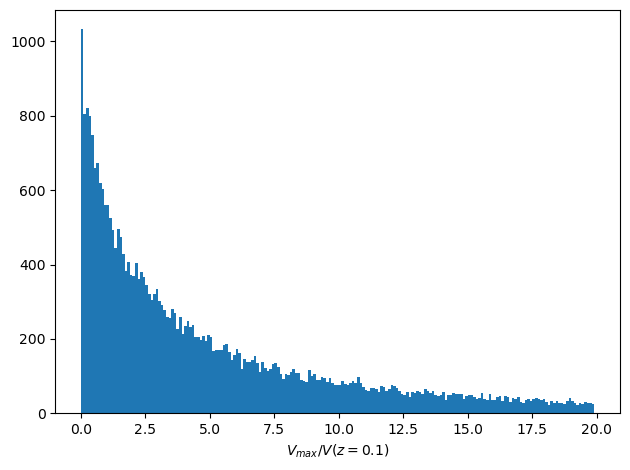

In [6]:
plt.figure(tight_layout=True)

plt.hist(sgatab['MAX_VOL_FRAC'], np.arange(0, 20, 0.1))

plt.xlabel('$V_{max}$/$V(z = 0.1)$');

## Convert to CMB frame

In [7]:
sgatab['Z_DESI_CMB'] = convert_z_frame(sgatab['Z_DESI'], sgatab['RA'], sgatab['DEC'])

# Load Morphological Classification

## SSL

As an alternative to morphological classification of the galaxies, we also produced a classification based on the SSL sorter (using a nearest-neighbor query; Largett et al., in prep.). The classification ignored the Hubble sub-types and grouped the galaxies into four main categories:
1. Spiral
2. Elliptical
3. Lenticular
4. Irregular

Let's also load this table and add it to the SGA table.

In [8]:
# ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv'
ai_morphpath = '.'
# ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv/SGA2020'
# ai_morphcsv = os.path.join(ai_morphpath, 'sga10278_morphologies_model_analysis.csv')
ai_morphcsv = '/global/homes/s/sgmoore1/DESI_SGA/TF/Y3/SGAY3TFMorphologies.csv'
ai_morphtab = Table.read(ai_morphcsv)
ai_morphtab

<Table length=35792>
  SGA_ID  Predicted_Type_spiral ... Predicted_Type_lenticular Predicted_Type
 float64           str6         ...           str10               str10     
--------- --------------------- ... ------------------------- --------------
 218203.0                 Other ...                     Other      Irregular
 218205.0                 Other ...                     Other      Irregular
 218239.0                 Other ...                     Other      Irregular
 218275.0                 Other ...                     Other      Irregular
 218304.0                Spiral ...                     Other         Spiral
 218367.0                 Other ...                     Other      Irregular
 218376.0                Spiral ...                     Other         Spiral
 218201.0                 Other ...                     Other      Irregular
 218385.0                Spiral ...                     Other         Spiral
 217784.0                 Other ...                     Other      Irregular
      ...                   ... ...                       ...            ...
 994412.0                 Other ...                     Other      Undecided
 994319.0                Spiral ...                     Other         Spiral
 997867.0                 Other ...                     Other      Undecided
    146.0                Spiral ...                     Other         Spiral
 607946.0                Spiral ...                     Other         Spiral
1078924.0                Spiral ...                     Other         Spiral
  10093.0                Spiral ...                     Other         Spiral
 668149.0                Spiral ...                     Other         Spiral
1266591.0                Spiral ...                     Other         Spiral
1265003.0                Spiral ...                     Other         Spiral

### Combine ML morphtypes with SGA catalog

In [9]:
sgatab = join(sgatab, ai_morphtab['SGA_ID', 'Predicted_Type'], keys='SGA_ID', join_type='left')

# Rename Predicted_Type to MORPHTYPE_AI
sgatab['Predicted_Type'].name = 'MORPHTYPE_AI'

## John Lucey's VI results

https://astro.dur.ac.uk/~jrl/DESI_TF_Y1/index.html

We are only considering galaxies that he considers bad for TF (strong asymmetry, double galaxies, stellar contamination).

In [10]:
lucey_VIpath = 'VI_JohnLucey/'

rejects = lucey_VIpath + 'REJECTS.txt'

reject_tab = Table.read(rejects, format='ascii.commented_header')
reject_tab['VI'] = 'reject'
reject_tab

<Table length=1052>
 SGA_ID       DESI_NAME            RA     ... R_MAG_SB26_ERR_CORR   VI  
 int64          str22           float64   ...       float64        str6 
------- ---------------------- ---------- ... ------------------- ------
    692 DESIXJ12411157+1819512 190.298193 ...              0.1382 reject
   2526 DESIXJ10124098+4543539 153.170765 ...              0.1699 reject
   2804 DESIXJ07581109+3420293 119.546191 ...              0.1966 reject
   3420 DESIXJ01135557+0034028   18.48153 ...              0.0664 reject
   5964 DESIXJ16261820+4219580  246.57584 ...              0.0339 reject
   6243 DESIXJ13403564+1214293 205.148492 ...              0.1067 reject
   6493 DESIXJ12450567+1054032 191.273606 ...              0.0329 reject
   6880 DESIXJ16001990+2910066  240.08293 ...              0.1591 reject
   7553 DESIXJ09534429-0005255 148.434553 ...              0.0685 reject
   8007 DESIXJ03051303-0700487  46.304307 ...              0.1576 reject
    ...                    ...        ... ...                 ...    ...
5001564 DESIXJ09492121+1202375 147.338388 ...              0.1481 reject
5001702 DESIXJ09193703+1523426 139.904289 ...              0.0421 reject
5001796 DESIXJ11101389+1810563 167.557891 ...              0.0521 reject
5001871 DESIXJ15154389+2019361 228.932863 ...              0.1544 reject
5001985 DESIXJ10551968+2331519 163.831986 ...              0.1216 reject
5002355 DESIXJ08432957+3521574 130.873225 ...              0.1276 reject
5002395 DESIXJ13480725+3655442 207.030213 ...              0.1564 reject
5002764 DESIXJ09531930+5225295 148.330411 ...              0.1378 reject
5002768 DESIXJ07223207+5244593 110.633643 ...              0.1596 reject
5002867 DESIXJ17290135+5656232 262.255625 ...              0.1167 reject

### Combine John's results with Y1 TF sample

In [11]:
sgatab = join(sgatab, reject_tab['SGA_ID', 'VI'], keys='SGA_ID', join_type='left')

# Rename VI column to JOHN_VI
sgatab['VI'].name = 'JOHN_VI'

In [12]:
sgatab[:5]

<Table length=5>
 SGA_ID  SGA_GALAXY          GALAXY         ... MORPHTYPE_AI JOHN_VI
                                            ...                     
float64   bytes16           bytes29         ...    str10       str6 
------- ----------- ----------------------- ... ------------ -------
   20.0 SGA-2020 20 SDSSJ173412.71+572041.6 ...    Irregular      --
   32.0 SGA-2020 32              PGC2644444 ...       Spiral      --
   38.0 SGA-2020 38 SDSSJ140638.88+393138.1 ...       Spiral      --
   53.0 SGA-2020 53  2MASXJ17023385+3640545 ...       Spiral      --
   55.0 SGA-2020 55              PGC1203947 ...       Spiral      --

# Photometric corrections

### Survey offsets

In [13]:
sys_corr, sys_corr_err = BASS_corr(sgatab['PHOTSYS'])

### MW dust corrections

In [14]:
# Import E(B-V) dust map
ebv_directory = '/global/cfs/cdirs/desicollab/users/rongpu/dust/desi_ebv/public_data/maps/'
# ebv_directory = '/Users/kdouglass/Documents/Research/data/DESI/'
ebv_filename = 'desi_dust_gr_512.fits'
ebv_map = Table.read(ebv_directory + ebv_filename)

In [15]:
MWdust_corr, MWdust_corr_err = MW_dust(sgatab['RA'], sgatab['DEC'], ebv_map)

/global/u1/s/sgmoore1/DESI_SGA/TF/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


In [16]:
# Flip NaN values to 0
MWdust_corr_err[np.isnan(MWdust_corr_err)] = 0

### $K$-corrections

In [17]:
# # Apparently we have some galaxies with negative redshifts
# zg0 = sgatab['Z_DESI'] >= 0

In [18]:
# kcorr_zg0 = k_corr(sgatab['Z_DESI'][zg0], 
#                    [sgatab['G_MAG_SB26'][zg0], sgatab['R_MAG_SB26'][zg0], sgatab['Z_MAG_SB26'][zg0]], 
#                    [sgatab['G_MAG_SB26_ERR'][zg0], sgatab['R_MAG_SB26_ERR'][zg0], sgatab['Z_MAG_SB26_ERR'][zg0]], 
#                    z_corr=0.1) # K-correcting to same redshift as FastSpecFit (which is what Caitlin's using for the FP)

In [19]:
# kcorr = np.zeros([len(sgatab), 3])
# kcorr[zg0] = kcorr_zg0

### Internal dust extinction correction

This is based off of a linear fit to ($b/a$, $m_r$), removing any correlation between $b/a$ and $m_r$.

In [43]:
# temp_infile = open('jura_internalDust_z0p1_mcmc.pickle', 'rb')
temp_infile = open('jura_internalDust_nokcorr_mcmc.pickle', 'rb') #without k-corr
dust_mcmc_samples_r,_, dust_mcmc_samples_g,_, dust_mcmc_samples_z,_ = pickle.load(temp_infile)
temp_infile.close()

In [44]:
internalDust_coeffs_r = np.median(dust_mcmc_samples_r, axis=1)
internalDust_coeffs_g = np.median(dust_mcmc_samples_g, axis=1)
internalDust_coeffs_z = np.median(dust_mcmc_samples_z, axis=1)

internalDust_coeffs_err_r = np.zeros(len(internalDust_coeffs_r))
internalDust_coeffs_err_g = np.zeros(len(internalDust_coeffs_g))
internalDust_coeffs_err_z = np.zeros(len(internalDust_coeffs_z))

internalDust_coeffs_err_r[0] = np.std(dust_mcmc_samples_r[0][(-1.5 < dust_mcmc_samples_r[0]) & (dust_mcmc_samples_r[0] < 0)])
internalDust_coeffs_err_r[1] = np.std(dust_mcmc_samples_r[1][(0 < dust_mcmc_samples_r[1]) & (dust_mcmc_samples_r[1] < 1)])

internalDust_coeffs_err_g[0] = np.std(dust_mcmc_samples_g[0][(-1.5 < dust_mcmc_samples_g[0]) & (dust_mcmc_samples_g[0] < 0)])
internalDust_coeffs_err_g[1] = np.std(dust_mcmc_samples_g[1][(0 < dust_mcmc_samples_g[1]) & (dust_mcmc_samples_g[1] < 1)])

internalDust_coeffs_err_z[0] = np.std(dust_mcmc_samples_z[0][(-1.5 < dust_mcmc_samples_z[0]) & (dust_mcmc_samples_z[0] < 0)])
internalDust_coeffs_err_z[1] = np.std(dust_mcmc_samples_z[1][(0 < dust_mcmc_samples_z[1]) & (dust_mcmc_samples_z[1] < 1)])

In [45]:
internalDust_corr_r, internalDust_corr_err_r = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_r, 
                                                             internalDust_coeffs_err_r)

internalDust_corr_g, internalDust_corr_err_g = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_g, 
                                                             internalDust_coeffs_err_g)

internalDust_corr_z, internalDust_corr_err_z = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_z, 
                                                             internalDust_coeffs_err_z)

## Apply corrections

In [46]:
# sgatab['G_MAG_SB26_CORR'] = sgatab['G_MAG_SB26'] - MWdust_corr[0] + sys_corr + kcorr[:,0] - internalDust_corr_g
# sgatab['R_MAG_SB26_CORR'] = sgatab['R_MAG_SB26'] - MWdust_corr[1] + sys_corr + kcorr[:,1] - internalDust_corr_r
# sgatab['Z_MAG_SB26_CORR'] = sgatab['Z_MAG_SB26'] - MWdust_corr[2] + sys_corr + kcorr[:,2] - internalDust_corr_z

In [47]:
# ##### without k-correction

# sgatab['G_MAG_SB26_CORR'] = sgatab['G_MAG_SB26'] - MWdust_corr[0] + sys_corr - internalDust_corr_g
# sgatab['R_MAG_SB26_CORR'] = sgatab['R_MAG_SB26'] - MWdust_corr[1] + sys_corr - internalDust_corr_r
# sgatab['Z_MAG_SB26_CORR'] = sgatab['Z_MAG_SB26'] - MWdust_corr[2] + sys_corr - internalDust_corr_z

In [17]:
#### no corrections
sgatab['G_MAG_SB26_CORR'] = sgatab['G_MAG_SB26']
sgatab['R_MAG_SB26_CORR'] = sgatab['R_MAG_SB26']
sgatab['Z_MAG_SB26_CORR'] = sgatab['Z_MAG_SB26']

sgatab['G_MAG_SB26_ERR_CORR'] = sgatab['G_MAG_SB26_ERR']
sgatab['R_MAG_SB26_ERR_CORR'] = sgatab['R_MAG_SB26_ERR']
sgatab['Z_MAG_SB26_ERR_CORR'] = sgatab['Z_MAG_SB26_ERR']

In [25]:
# sgatab['G_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['G_MAG_SB26_ERR']**2 + MWdust_corr_err[0]**2 + sys_corr_err**2 + internalDust_corr_err_g**2)
# sgatab['R_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['R_MAG_SB26_ERR']**2 + MWdust_corr_err[1]**2 + sys_corr_err**2 + internalDust_corr_err_r**2)
# sgatab['Z_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['Z_MAG_SB26_ERR']**2 + MWdust_corr_err[2]**2 + sys_corr_err**2 + internalDust_corr_err_z**2)

# Apply Cuts Suitable for Calibrating the TFR

Requirements:
* $10~\mathrm{km/s} < V_\mathrm{rot} < 1000~\mathrm{km/s}$ at $0.4R_{26}$
* $\Delta V/V_\mathrm{min} \leq 5$
* Passed visual inspection (both ours and John Lucey's)
* $i > 45^\circ$
* Spiral-type morphology
* Not an outlier (as found in the `TF_Y1_clustering.ipynb` notebook)

The first 2.5 items have already been applied (our VI results have already been applied, but not John's).

In [18]:
sgatab['MU_ZCMB'] = Planck18_h.distmod(sgatab['Z_DESI_CMB'])

sgatab['R_ABSMAG_SB26'] = sgatab['R_MAG_SB26_CORR'] - sgatab['MU_ZCMB'].value
sgatab['G_ABSMAG_SB26'] = sgatab['G_MAG_SB26_CORR'] - sgatab['MU_ZCMB'].value
sgatab['Z_ABSMAG_SB26'] = sgatab['Z_MAG_SB26_CORR'] - sgatab['MU_ZCMB'].value

r_data = np.array([sgatab['R_ABSMAG_SB26'], np.log10(sgatab['V_0p4R26'])])
g_data = np.array([sgatab['G_ABSMAG_SB26'], np.log10(sgatab['V_0p4R26'])])
z_data = np.array([sgatab['Z_ABSMAG_SB26'], np.log10(sgatab['V_0p4R26'])])

clusterer = HDBSCAN(cluster_selection_epsilon=0.04)

clusterer.fit(r_data.T)
# r_outlier_boolean = clusterer.labels_ != 53
# r_outlier_boolean = clusterer.labels_ != 51 #no k-corr
r_outlier_boolean = clusterer.labels_ != 48 #no corrections

clusterer.fit(g_data.T)
# g_outlier_boolean = clusterer.labels_ != 50
g_outlier_boolean = clusterer.labels_ != 58 #no k-corr

clusterer.fit(z_data.T)
z_outlier_boolean = clusterer.labels_ != 52 #same in both cases

## if we want any galaxy in bulk population of any band
outlier_boolean_2 = (r_outlier_boolean & g_outlier_boolean & z_outlier_boolean)

## only galaxies in the bulk population for all 3 bands
# outlier_boolean = ~(~r_outlier_boolean & ~g_outlier_boolean & ~z_outlier_boolean)
outlier_boolean = r_outlier_boolean
# This limit was determined in the TF_Y3_clustering.ipynb notebook

In [19]:
print(np.sum(r_outlier_boolean))
print(np.sum(g_outlier_boolean))
print(np.sum(z_outlier_boolean))
np.sum(outlier_boolean)

2347
35662
35630


2347

In [20]:
#- Inclination cut
cosi2 = (sgatab['BA']**2 - q0**2) / (1 - q0**2)
i_min = 45. * u.degree
cosi2_max = np.cos(i_min)**2
is_good_incl = cosi2 < cosi2_max

#- Morphology cut: only ML
is_good_morph_ML = np.zeros_like(is_good_incl, dtype=bool)
for i in range(len(sgatab)):
    if sgatab['MORPHTYPE_AI'][i] == 'Spiral':
        is_good_morph_ML[i] = True

#- John's VI
is_good_John = sgatab['JOHN_VI'].mask

#- Combine selections:
is_good_sga = is_good_incl & is_good_morph_ML & is_good_John & ~outlier_boolean

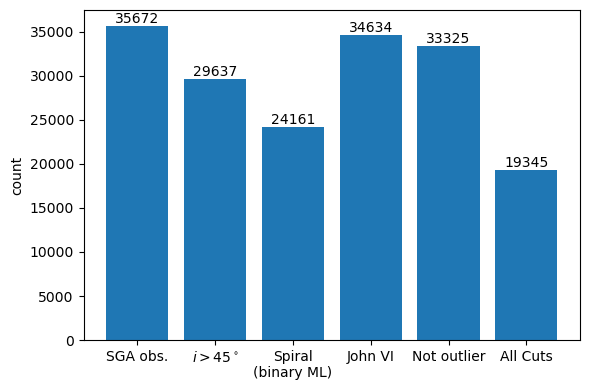

In [21]:
data = {
    'SGA obs.' : len(sgatab),
    # r'$10 < V_\mathrm{rot} < 1000$' : np.sum(is_good_velo),
    # r'$\Delta V/V_\mathrm{min}>5$' : np.sum(is_good_dv),
    r'$i > 45^\circ$' : np.sum(is_good_incl), 
    # 'Spiral' : np.sum(is_good_morph),
    'Spiral\n(binary ML)' : np.sum(is_good_morph_ML),
    'John VI' : np.sum(is_good_John), 
    # 'Not dwarf' : np.sum(~dwarf_boolean), 
    'Not outlier' : np.sum(~outlier_boolean), 
    'All Cuts' : np.sum(is_good_sga), 
    # 'All Cuts\n(binary ML)' : np.sum(is_good_sga_ML)
}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(6,4), tight_layout=True)
bars = ax.bar(names, values, color='tab:blue')
ax.bar_label(bars, fmt='%d')
ax.set(ylabel='count');#, yscale='log', ylim=[1e3,1.2e4]);

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_cuts.png', dpi=150, facecolor='none');

# Redshift bins

Separate the galaxies into redshift bins of width 0.005, starting at a redshift of 0.03.  (PVs are a significant fraction of the redshift at redshifts less than this.)

In [22]:
zmin = 0.03
zmax = 0.1
dz = 0.005
zbins = np.arange(zmin, zmax, dz)

#- SGA galaxies that passed quality selection
sgatab_sel = sgatab[is_good_sga]

zbin_indices = np.digitize(sgatab_sel['Z_DESI_CMB'], zbins, right=True)

In [23]:
for i in range(len(zbins) + 1):
    if i == 0:
        print(f'{i:2d}  z <= {zbins[i]:0.3f}  {np.sum(zbin_indices == i):3d} galaxies')
    elif i == len(zbins):
        print(f'{i:2d}  z > {zbins[i-1]:0.3f}  {np.sum(zbin_indices == i):3d} galaxies')
    else:
        print(f'{i:2d}  {zbins[i-1]:0.3f} < z <= {zbins[i]:0.3f}  {np.sum(zbin_indices == i):3d} galaxies')

 0  z <= 0.030  2600 galaxies
 1  0.030 < z <= 0.035  1461 galaxies
 2  0.035 < z <= 0.040  1331 galaxies
 3  0.040 < z <= 0.045  1314 galaxies
 4  0.045 < z <= 0.050  1183 galaxies
 5  0.050 < z <= 0.055  1218 galaxies
 6  0.055 < z <= 0.060  1152 galaxies
 7  0.060 < z <= 0.065  1210 galaxies
 8  0.065 < z <= 0.070  1170 galaxies
 9  0.070 < z <= 0.075  1005 galaxies
10  0.075 < z <= 0.080  963 galaxies
11  0.080 < z <= 0.085  961 galaxies
12  0.085 < z <= 0.090  726 galaxies
13  0.090 < z <= 0.095  522 galaxies
14  0.095 < z <= 0.100  399 galaxies
15  z > 0.100  2130 galaxies


In [24]:
_, counts = np.unique(zbin_indices, return_counts=True)

print(np.min(counts[1:-1]), np.max(counts[1:-1]))

399 1461


# Build the Calibration Table of SGA Galaxies

In [25]:
sgatab_sel['Z_BIN_IDX'] = zbin_indices

no_use = (zbin_indices == 0) | (zbin_indices == len(zbins))
caltab = sgatab_sel[~no_use]

rejtab = sgatab_sel[no_use]

# caltab.write('SGA-2020_iron_Vrot_cluster_calib_z0p1_Anthony2_dVsys.fits', overwrite=True)
caltab[['Z_BIN_IDX', 'Z_DESI_CMB', 'SGA_ID', 'R_MAG_SB26_CORR', 'R_MAG_SB26_ERR_CORR',  'V_0p4R26', 'V_0p4R26_ERR', 'G_MAG_SB26_CORR', 'G_MAG_SB26_ERR_CORR', 'Z_MAG_SB26_CORR', 'Z_MAG_SB26_ERR_CORR']]

<Table length=14615>
Z_BIN_IDX      Z_DESI_CMB        SGA_ID  ... Z_MAG_SB26_CORR Z_MAG_SB26_ERR_CORR
  int64         float64         float64  ...     float32           float32      
--------- -------------------- --------- ... --------------- -------------------
       14  0.09584227550618851      32.0 ...       15.448293         0.023631034
       11  0.08162259792451398      38.0 ...       17.178627          0.03649375
       14  0.09910676616970915      53.0 ...       16.169716         0.007657998
        4   0.0450825224094471      55.0 ...       17.270563         0.018187799
        4  0.04576246551386931      63.0 ...       16.791212          0.03895229
        2 0.039043619899402415      74.0 ...       16.354862         0.029606054
        6  0.05562909723504572      76.0 ...        16.13258         0.029357912
       13  0.09120672548251285     117.0 ...       16.060444          0.03365211
        3 0.044272217700709104     149.0 ...       15.848424          0.01395184
        9  0.07161938357108588     209.0 ...        16.18849         0.018908761
      ...                  ...       ... ...             ...                 ...
        1  0.03219009683772134 5002752.0 ...       17.744785         0.022286164
       11  0.08439316669485941 5002770.0 ...       17.358507         0.044119716
        7  0.06442597350070356 5002784.0 ...       17.454552          0.03130589
        4  0.04690862581750688 5002833.0 ...       17.192457           0.0412202
        5 0.051815458604373976 5002893.0 ...         18.3344         0.012465538
       10   0.0798357571882582 5002936.0 ...         17.9681          0.01047282
       12  0.08767488106218857 5002979.0 ...        17.11618         0.019253295
        4 0.048714295429855836 5002994.0 ...       18.206432         0.030764705
        6  0.05533204390688584 5003004.0 ...        19.27636         0.051400226
        6  0.05684489455363129 5003075.0 ...       17.038376         0.030709643

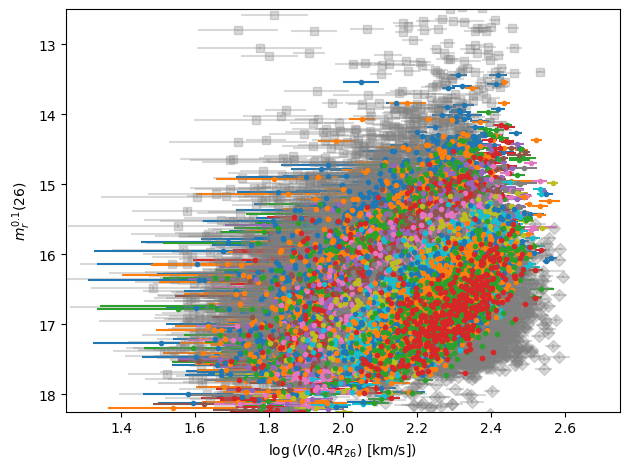

In [26]:
# fig, axes = plt.subplots(1, 2, figsize=(8,6), sharex=True, tight_layout=True)
fig, axes = plt.subplots(1, 1, tight_layout=True)

logV0 = 0

# ax = axes[0] 
ax = axes

#-------------------------------------------------------------------------------
# Plot galaxies with failed cluster selections.
#-------------------------------------------------------------------------------
_zbin_ids = np.unique(rejtab['Z_BIN_IDX'])
markers = 'sDv^<>'
for j, _zbin_id in enumerate(_zbin_ids):
    select_zbin = np.isin(rejtab['Z_BIN_IDX'], _zbin_id)

    #- Store independent variable for each cluster
    logv = np.log10(rejtab['V_0p4R26'][select_zbin].data) - logV0
    logv_err = 0.434*rejtab['V_0p4R26_ERR'][select_zbin].data / rejtab['V_0p4R26'][select_zbin].data

    #- Store dependent variable for each cluster
    mr26 = rejtab['R_MAG_SB26_CORR'][select_zbin].data
    mr26_err = rejtab['R_MAG_SB26_ERR_CORR'][select_zbin].data

    if _zbin_id == 0:
        ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, 
                    fmt=markers[j % 2], markersize=6, color='gray', alpha=0.3, 
                    label=f'z $\leq$ {zbins[_zbin_id]:.3f} (rej.)')
    else:
        ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, 
                    fmt=markers[j % 2], markersize=6, color='gray', alpha=0.3, 
                    label=f'z > {zbins[_zbin_id-1]:.3f} (rej.)')
#-------------------------------------------------------------------------------
# Plot galaxies and clusters passing all selections.
#-------------------------------------------------------------------------------
_zbin_ids = np.unique(caltab['Z_BIN_IDX'])

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,len(_zbin_ids)+1)))

for _zbin_id in _zbin_ids:
    select_zbin = np.isin(caltab['Z_BIN_IDX'], _zbin_id)

    #- Store independent variable for each cluster
    logv = np.log10(caltab['V_0p4R26'][select_zbin].data) - logV0
    logv_err = 0.434*caltab['V_0p4R26_ERR'][select_zbin].data / caltab['V_0p4R26'][select_zbin].data

    #- Store dependent variable for each cluster
    mr26 = caltab['R_MAG_SB26_CORR'][select_zbin].data
    mr26_err = caltab['R_MAG_SB26_ERR_CORR'][select_zbin].data
    
    ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='.', 
                label=f'{zbins[_zbin_id-1]:.3f}-{zbins[_zbin_id]:.3f}')
#-------------------------------------------------------------------------------

ax.set(xlim=[1.25, 2.75],
       xlabel=r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)',
       ylim=[18.25, 12.5],
       ylabel=r'$m_r^{0.1} (26)$');

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_0pt_binaryMLupdated_20241203.png', dpi=150);

# Apply the Joint TFR Fit

In [27]:
#- Extract successful clusters
_zbin_ids = np.unique(caltab['Z_BIN_IDX'])
m = len(_zbin_ids)

#- Pack the results into arrays data and cov.
logV, logV_err = [], []
mag, mag_err = [], []
weights = []

logV0 = np.median(np.log10(caltab['V_0p4R26']))
print('logV0 =', logV0)

#- Loop over the redshift bins
for k, _zbin_id in enumerate(_zbin_ids):
    select_zbin = np.isin(caltab['Z_BIN_IDX'], _zbin_id)
    logV.append(np.log10(caltab['V_0p4R26'][select_zbin]) - logV0)
    logV_err.append(0.434*caltab['V_0p4R26_ERR'][select_zbin] / caltab['V_0p4R26'][select_zbin])
    mag.append(caltab['R_MAG_SB26_CORR'][select_zbin])
    mag_err.append(caltab['R_MAG_SB26_ERR_CORR'][select_zbin])
    weights.append(np.array(1/caltab['MAX_VOL_FRAC'][select_zbin]))

logV0 = 2.1806672031276313


## Multiline Fit using HyperFit

In [28]:
bounds = [[-20, 0]]                    # Bounds on a (slope)
bounds += m*[(-20, 20)]                # Bounds on b (intercepts: z-bins)
bounds += [(0,5)]                      # Bounds on sigma

results = hyperfit_line_multi(logV, mag, logV_err, mag_err, bounds, weights=weights, scatter=1)

a, b, sig_tfr, cov_tfr, tfr_mcmc_samples, hf_tfr = results

     fun: -12442336.214513097
     jac: array([  19.37150967,  103.93559073,   12.47972147,   60.90849134,
         31.66496492,   18.06765645,   21.42041744,  -15.64621796,
         10.05828297,  -87.17178577,  -93.69104325,  -17.32259845,
       -106.72955822,  -53.08538236,  -88.66190177,  325.40410774])
 message: 'Optimization terminated successfully.'
    nfev: 36323
     nit: 149
 success: True
       x: array([-6.89497461, 15.26828768, 15.55597885, 15.78382645, 16.00097414,
       16.22741975, 16.39069028, 16.59186941, 16.73950931, 16.90045677,
       17.03292531, 17.18609405, 17.29074771, 17.46131793, 17.57520893,
        0.45291017])
Ndim: 16 14


100%|██████████| 1000/1000 [00:59<00:00, 16.81it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [87.94359382 37.72227342 28.46120993 25.65546793 22.45627254 28.93027693
 35.6359696  74.34252688 31.61596723 33.30941819 60.90546532 89.51372947
 48.92180674 86.86991915 54.73296771 87.80924301] / 4475.68647325151


100%|██████████| 1000/1000 [01:00<00:00, 16.43it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [69.35076927 35.19912735 24.14614252 23.25144186 27.29126675 25.56955927
 35.08995859 50.8501613  37.6486464  43.10338905 60.53120038 55.94064196
 67.81030982 78.24008223 75.89202896 93.84761565] / 4692.380782588321


100%|██████████| 1000/1000 [01:01<00:00, 16.20it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 81.91534985  40.51796809  25.16908492  23.116096    31.06812324
  32.87402215  58.97266209  55.6121743   35.08856999  53.75989322
  80.66388711  61.27083831  80.73074151  89.19755199 102.27775209
 125.17035306] / 6258.51765314979


100%|██████████| 1000/1000 [01:00<00:00, 16.53it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [118.75024032  39.96361721  27.11060558  24.35348331  34.45657916
  34.51473972  57.09915772  52.93421204  39.20819776  51.35060559
  79.14483959  61.06822364  71.41832851  85.64576817 113.62278609
 112.85188343] / 5937.512016102342


100%|██████████| 1000/1000 [01:00<00:00, 16.64it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [132.82528811  35.91868547  26.91284768  23.78949729  36.44620899
  34.46367435  58.64034317  55.92872195  41.52827588  60.82957701
  79.70304742  55.58379396  75.06380877 105.35115334 142.27570649
 124.32189587] / 7113.785324667199


100%|██████████| 1000/1000 [00:58<00:00, 17.21it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [128.85887219  27.34368323  27.34569618  23.40750664  33.48907642
  30.90721695  37.28993596  50.57473421  44.92302117  57.57575134
  59.58709759  57.80719131  73.04477302 107.78477053  96.62664857
 121.55583901] / 6442.943609481421


100%|██████████| 1000/1000 [00:58<00:00, 16.96it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [121.62643505  30.61867431  27.43384406  25.33120141  32.16697047
  29.68964589  42.39302495  61.73966875  53.11168216  52.12434756
  74.80507832  53.88237064 123.09648216 111.66910982  98.31705181
 125.46480725] / 6273.240362566436


100%|██████████| 1000/1000 [01:00<00:00, 16.44it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [104.08792768  30.93446503  31.17574343  25.77132605  31.836968
  30.27223721  41.05062303  63.06015065  50.63706028  63.48051026
  74.88083791  60.18466207 128.36079224 106.00574508  93.63718371
 116.19323142] / 6418.039611982284


100%|██████████| 1000/1000 [01:00<00:00, 16.45it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [113.46267148  30.36353762  31.20255392  25.8337853   30.22053081
  29.35987177  39.65084584  63.83667686  47.47142798  58.24451151
  75.58903453  58.5144564  135.47933325 105.58119956  99.74130248
 115.12911389] / 6773.9666622812365


100%|██████████| 1000/1000 [00:59<00:00, 16.68it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [112.44612809  30.57654057  35.29620082  26.16509492  30.75208139
  29.89681602  40.01070804  60.50706133  47.7795694   60.03170158
  75.36629456 102.14019936 141.7399317  102.55802265  99.95486071
 116.74945919] / 7086.996584940171


100%|██████████| 1000/1000 [01:01<00:00, 16.18it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [116.08713991  32.8979963   33.81738211  26.33185736  36.79787434
  31.1506615   38.99249734  64.44225473  55.37834856  67.7357356
  75.12339397 105.21550987 133.26308491 111.38635642 150.8048837
 117.26970745] / 7540.244184865615


100%|██████████| 1000/1000 [01:04<00:00, 15.62it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [109.9759353   32.71352434  34.33811782  26.39178522  37.26723528
  31.88898317  43.45839976  63.86811406  58.50125088  68.89659668
  75.06047093 110.12107693 139.19615513 109.07563979 147.66525783
 117.71652296] / 7383.2628913284125


100%|██████████| 1000/1000 [01:00<00:00, 16.48it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [106.76303665  33.10542627  34.34714258  26.51345202  33.99633501
  32.19540156  44.348333    66.5931949   60.5526433   67.35739752
  84.87983559 100.13218562 140.88302465 123.15087705 148.649303
 205.12517755] / 10256.258877345334


100%|██████████| 1000/1000 [00:59<00:00, 16.89it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [110.12535407  31.66601789  34.63332387  24.74476301  36.55657271
  37.32784052  42.56087038  60.6613282   59.5692759   76.32844419
  78.23400938 139.70283504  99.02084346 115.3011536  146.17938412
 271.5686482 ] / 13578.432410245952


100%|██████████| 1000/1000 [00:58<00:00, 17.11it/s]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [109.79031837  31.60882913  33.76660751  24.53482496  36.21939183
  38.8264985   43.89736933  61.67070502  56.69026442  74.13164124
  81.31407364 130.93518072  98.90305271 108.13952699 141.73084271
 304.18146428] / 15209.073214153643


100%|██████████| 1000/1000 [01:03<00:00, 15.74it/s]


Niterations/Max Iterations:  16000 / 100000
Integrated ACT/Min Convergence Iterations:  [105.10487377  31.89442941  33.17623391  25.27416757  36.68803506
  38.57046236  44.83533776  59.52154095  57.99150251  70.44303778
  85.74591867 127.41667211 123.18138738 104.42900582 142.08248083
 292.09044785] / 14604.522392254537


100%|██████████| 1000/1000 [01:00<00:00, 16.64it/s]


Niterations/Max Iterations:  17000 / 100000
Integrated ACT/Min Convergence Iterations:  [104.47573919  31.26507851  33.70906201  24.66744057  35.19358652
  39.58916696  43.27494701  64.91668206  54.91774401  71.09292406
  82.79446639 115.25761305 146.58225089 101.14263431 153.78317437
 280.66071369] / 14033.035684705814


100%|██████████| 1000/1000 [01:01<00:00, 16.34it/s]


Niterations/Max Iterations:  18000 / 100000
Integrated ACT/Min Convergence Iterations:  [151.3316304   31.78289304  33.47679936  25.16271742  34.27790412
  42.24096328  43.01964488  65.38737482  58.51172217  71.52184504
  87.68997847 182.14100441 145.95959292 103.75500174 151.8039076
 249.93168164] / 12496.584082181445


100%|██████████| 1000/1000 [01:03<00:00, 15.78it/s]


Niterations/Max Iterations:  19000 / 100000
Integrated ACT/Min Convergence Iterations:  [146.17564021  31.697698    33.34831569  25.93454902  33.25165842
  40.64155774  42.16193865  64.85719356  56.71866055  68.08591285
  94.53986849 175.17533008 144.46565443 102.29672812 148.95710754
 235.52875394] / 11776.43769704201


100%|██████████| 1000/1000 [01:02<00:00, 16.01it/s]


Niterations/Max Iterations:  20000 / 100000
Integrated ACT/Min Convergence Iterations:  [146.39483914  30.98585172  31.16836956  25.79007747  33.74087518
  40.15821683  41.93309508  63.1346812   52.57465512  70.37193875
  92.44402442 163.52027443 147.49641738 102.19949599 151.39656918
 232.16441311] / 11608.220655464906


100%|██████████| 1000/1000 [00:59<00:00, 16.91it/s]


Niterations/Max Iterations:  21000 / 100000
Integrated ACT/Min Convergence Iterations:  [143.92737375  31.91937838  31.41496246  30.65224899  33.651778
  38.52761695  45.25750966  63.88008157  66.18180594  67.52285534
  89.74230824 157.31752754 141.57375397 104.62198825 164.07086532
 238.00830214] / 11900.415106821178


100%|██████████| 1000/1000 [01:01<00:00, 16.15it/s]


Niterations/Max Iterations:  22000 / 100000
Integrated ACT/Min Convergence Iterations:  [132.50185736  31.68973864  33.71380206  31.295278    33.76626298
  41.61542271  48.22265729  68.78424674  61.08506158  64.46509047
  87.72436854 155.94156595 150.28965909 118.88551308 243.09891198
 198.72156728] / 12154.945598782439


100%|██████████| 1000/1000 [00:57<00:00, 17.27it/s]


Niterations/Max Iterations:  23000 / 100000
Integrated ACT/Min Convergence Iterations:  [128.06386371  30.99990671  32.96534235  30.17478131  34.04118748
  40.72187289  47.91948524  68.62830435  58.37753115  62.8211223
  89.23048574 151.14057407 143.51341716 120.11781911 248.56103
 189.33539854] / 12428.051499753581


In [29]:
temp_outfile = open('/pscratch/sd/s/sgmoore1/TF/pickles/Y3/cov_ab_jura_jointTFR_HDBSCAN_r_band_nocorr.pickle', 
                    'wb')
pickle.dump((cov_tfr, tfr_mcmc_samples, logV0, zmin, zmax, dz, zbins), temp_outfile)
temp_outfile.close()

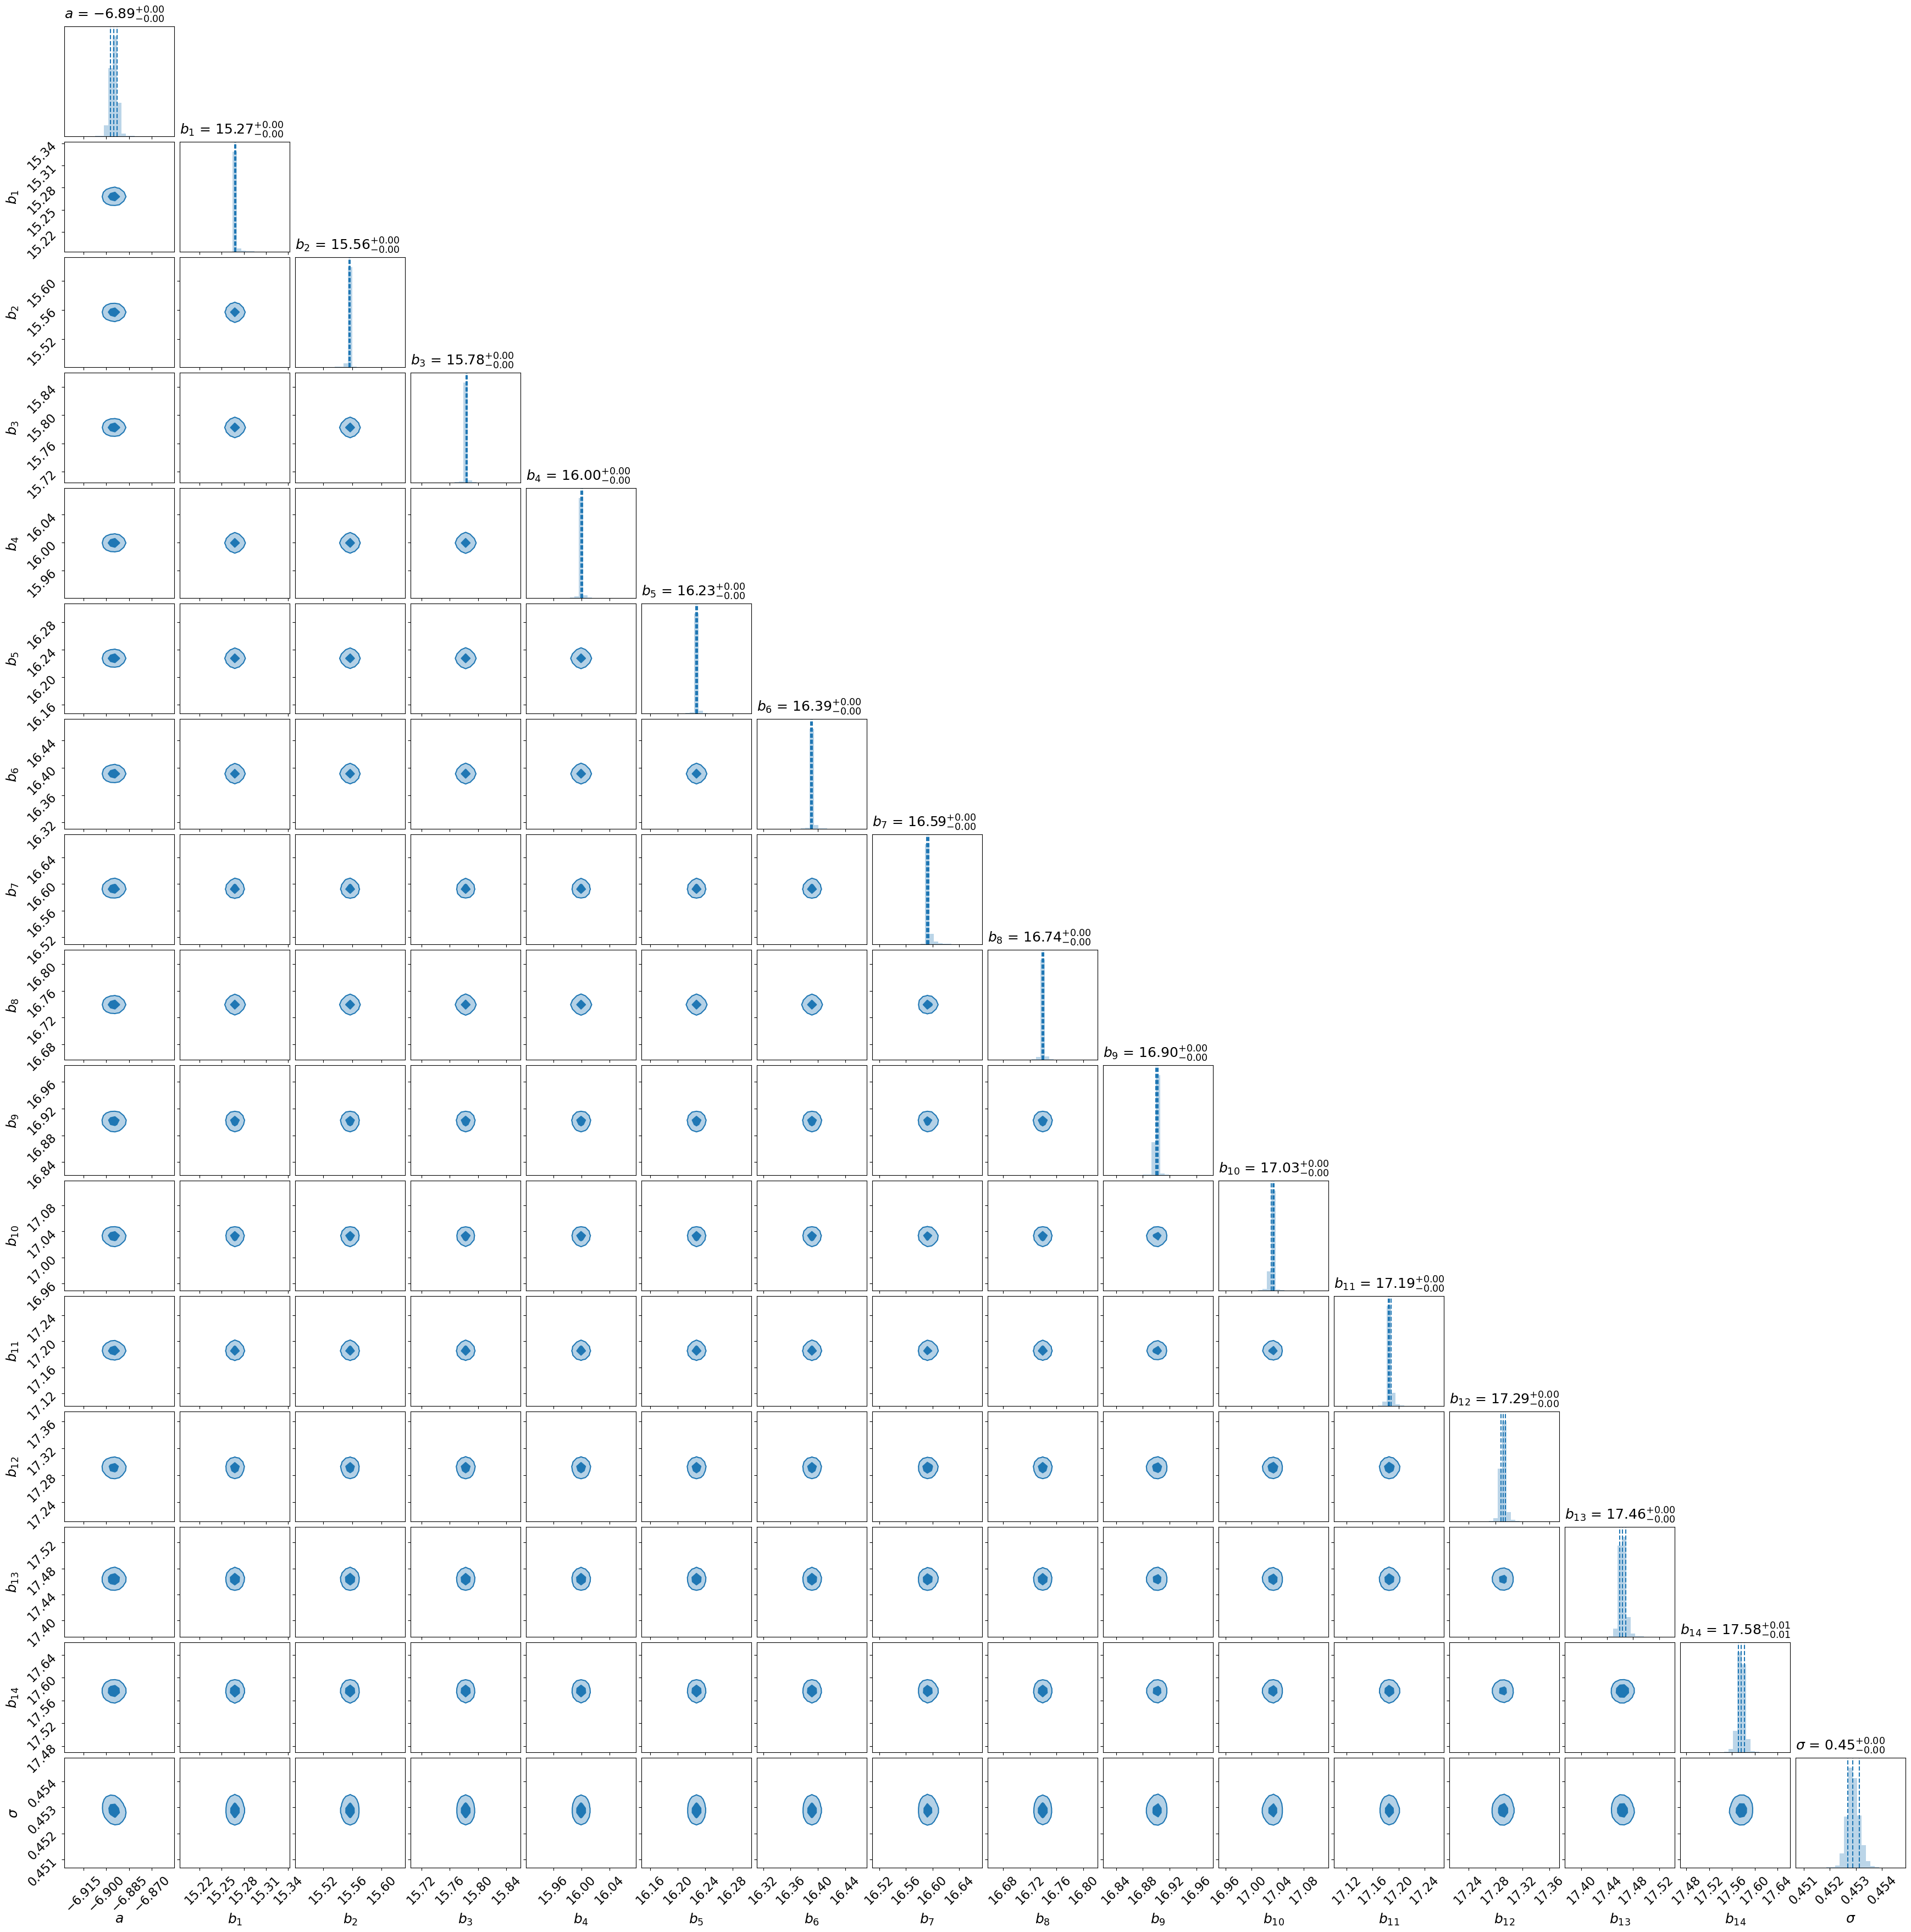

In [30]:
labels  = ['$a$']
labels += [f'$b_{{ {k+1} }}$' for k in np.arange(m)]
labels += [r'$\sigma$'] #+ [rf'$\sigma_{k}$' for k in np.arange(m)]

fig = corner(tfr_mcmc_samples.T, bins=25, smooth=1,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='tab:blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16)

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_corner0_20250717.png', 
#             dpi=150, 
#             facecolor='none');

### Plot the HyperFit Results

In [31]:
sigma_mcmc = np.percentile(tfr_mcmc_samples[-1], [16., 50., 84.])
a_mcmc = np.percentile(tfr_mcmc_samples[0], [16., 50., 84])
b_mcmc = []
# for k in range(1, m+2):
for k in range(1, m+1):
    b_mcmc.append(np.percentile(tfr_mcmc_samples[k], [16., 50., 84.]))
b_mcmc = np.asarray(b_mcmc)

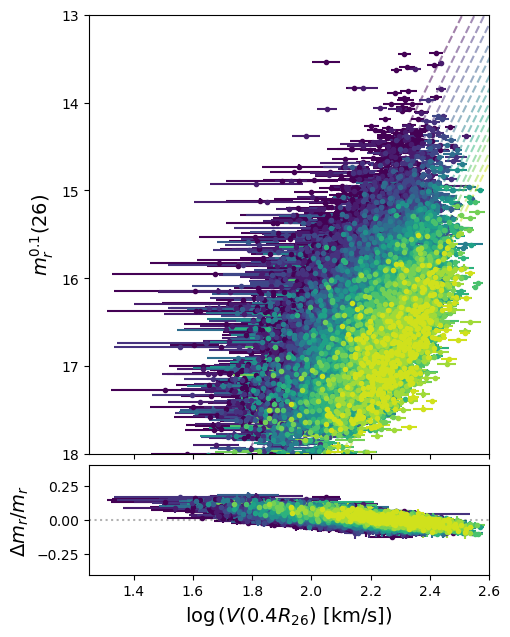

In [32]:
# fig, axes = plt.subplots(2,2, figsize=(10,7), sharex=True,
fig, axes = plt.subplots(2,1, figsize=(5,7), sharex=True,
                         gridspec_kw={'height_ratios':[4,1], 'hspace':0.04, 'wspace':0.25})

a_   = a_mcmc[1]
# b0pt = b_mcmc[0,1]
b_   = b_mcmc[:,1]#[1:]

#- Plot redshift bins
# ax = axes[0,0]
ax = axes[0]

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,m)))

_logv = np.arange(0, 3, 0.1) - logV0
for k in range(m):
    eb = ax.errorbar(x=logV0 + logV[k],#+1], 
                     y=mag[k],#+1], 
                     xerr=logV_err[k],#+1], 
                     yerr=mag_err[k],#+1],
                     fmt='.', 
                     label=f'{zbins[k]:.3f}-{zbins[k+1]:.3f}')

    ax.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), ls='--', alpha=0.5)

ax.set(xlim=[1.25, 2.6],
       ylim=[18, 13])
ax.set_ylabel(r'$m_r^{0.1} (26)$', fontsize=14)
# ax.legend(loc='upper left', fontsize=9, ncol=2);
'''
#- Plot calibrators
ax = axes[0,1]
eb = ax.errorbar(x=logV[0] + logV0, y=mag[0], xerr=logV_err[0], yerr=mag_err[0],
                 fmt='.', color='tab:blue', label=f'0-pt')

ax.plot(_logv + logV0, a_*_logv + b0pt, color=eb[0].get_color(), ls='--')#, label='fit')
ax.set(xlim=[1.25, 2.6],
       ylim=[-18, -24]
      )
ax.set_ylabel(r'$M_r^{0.1}(26) = m_r^{0.1}(26) - \mu$', fontsize=14)
ax.legend(loc='upper left', fontsize=9, ncol=2)
'''
#- Plot residuals: z-bins
# ax = axes[1,0]
ax = axes[1]

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,m)))

for k in range(m):
    logv_obs = logV[k]#+1]
    m_obs = mag[k]#+1]
    m_exp = (a_*logv_obs + b_[k])
    eb = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, 
                     xerr=logV_err[k],#+1], 
                     yerr=mag_err[k],#+1],
                     fmt='.')

ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1.25, 2.6],
       ylim=[-0.4, 0.4])
ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta m_r/m_r$', fontsize=14)
'''
#- Plot residuals: calibrators
ax = axes[1,1]

logv_obs = logV[0]
m_obs = mag[0]
m_exp = (a_*logv_obs + b0pt)

b = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, 
                xerr=logV_err[0], yerr=mag_err[0],
                fmt='.', color='tab:blue')
ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1.25, 2.6],
       ylim=[-0.4, 0.4])
ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta M_r/M_r$', fontsize=14)
'''
fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9);

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_0pt_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_fit0_20250717.png', 
#             dpi=150, 
#             facecolor='none')

In [33]:
print(f'slope (alpha): {-a_/2.5:.2f} +/- {np.sqrt(cov_tfr[0,0])/2.5:.3f}')

slope (alpha): 2.76 +/- 0.001


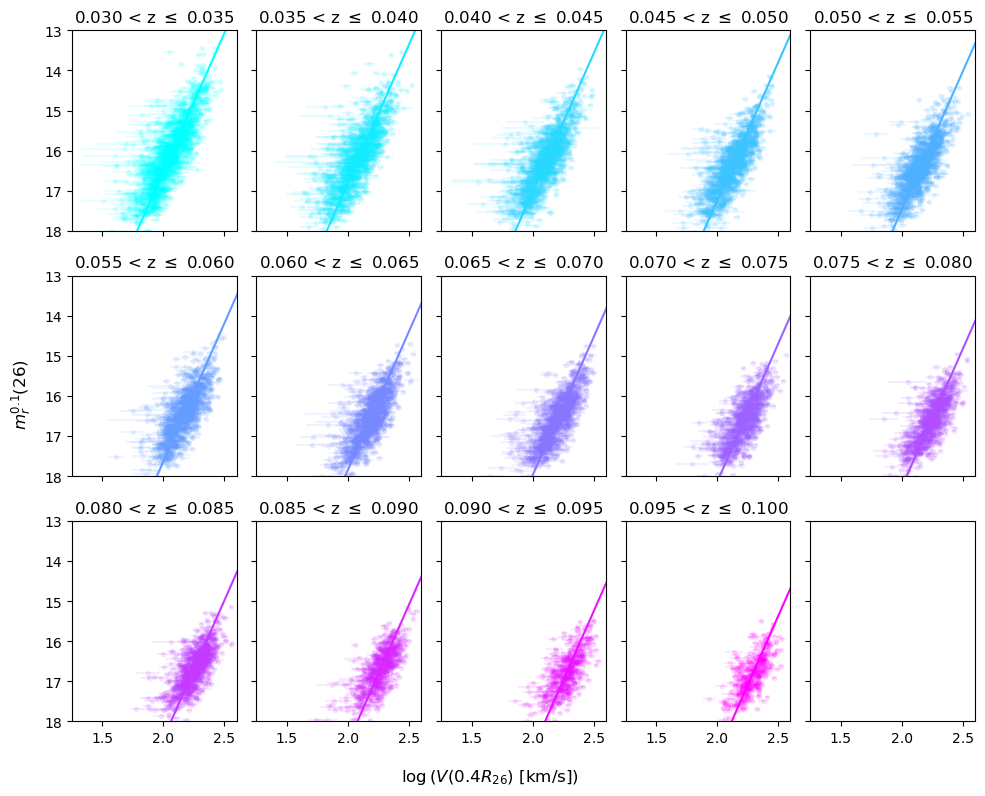

In [34]:
# fig, axs = plt.subplots(nrows=7, ncols=10, sharex=True, sharey=True, figsize=(20,16), tight_layout=True)
fig, axs = plt.subplots(nrows=3, ncols=5, sharex=True, sharey=True, figsize=(10,8), tight_layout=True)

color = iter(plt.cm.cool(np.linspace(0,1,m)))
for i in range(m):
    c = next(color)
    
    row = int(i/5)
    col = i%5
    
    eb = axs[row,col].errorbar(logV0 + logV[i],#+1], 
                               mag[i],#+1], 
                               xerr=logV_err[i],#+1], 
                               yerr=mag_err[i],#+1], 
                               fmt='.', color=c, alpha=0.1)
    axs[row,col].plot(_logv + logV0, a_*_logv + b_[i], color=c)
    
    axs[row,col].set(xlim=[1.25, 2.6], ylim=[18, 13], title=f'{zbins[i]:.3f} < z $\leq$ {zbins[i+1]:.3f}')

# Delete extra axes
# fig.delaxes(axs[-1,-1])

fig.supxlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)')
fig.supylabel(r'$m_r^{0.1} (26)$');

# plt.savefig('../../Figures/Y1/TF_Y1_individual_cluster_calibration_0pt_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_fit0_20250717.png', 
#             dpi=150, 
#             facecolor='none')

# Apply TFR fit on g-band

In [43]:
#- Extract successful clusters
_zbin_ids = np.unique(caltab['Z_BIN_IDX'])
m = len(_zbin_ids)

#- Pack the results into arrays data and cov.
logV, logV_err = [], []
mag, mag_err = [], []
weights = []

logV0 = np.median(np.log10(caltab['V_0p4R26']))
print('logV0 =', logV0)

#- Loop over the redshift bins
for k, _zbin_id in enumerate(_zbin_ids):
    select_zbin = np.isin(caltab['Z_BIN_IDX'], _zbin_id)
    logV.append(np.log10(caltab['V_0p4R26'][select_zbin]) - logV0)
    logV_err.append(0.434*caltab['V_0p4R26_ERR'][select_zbin] / caltab['V_0p4R26'][select_zbin])
    mag.append(caltab['G_MAG_SB26_CORR'][select_zbin])
    mag_err.append(caltab['G_MAG_SB26_ERR_CORR'][select_zbin])
    weights.append(np.array(1/caltab['MAX_VOL_FRAC'][select_zbin]))

logV0 = 2.1816598102975977


## Multiline Fit using HyperFit

In [44]:
bounds = [[-20, 0]]                    # Bounds on a (slope)
bounds += m*[(-20, 20)]                # Bounds on b (intercepts: z-bins)
bounds += [(0,5)]                      # Bounds on sigma

results = hyperfit_line_multi(logV, mag, logV_err, mag_err, bounds, weights=weights, scatter=1)

a, b, sig_tfr, cov_tfr, tfr_mcmc_samples, hf_tfr = results

     fun: -11808557.202456677
     jac: array([-87.17179351, -67.98654232, -20.30283045, -18.06765645,
        28.68473292, -31.10617142,  70.22171632, -64.82004583,
       -96.11248175,  -5.21540599,  36.6941064 ,  68.54533582,
         7.07805098,  31.47870042,  87.91684377, 130.75768954])
 message: 'Optimization terminated successfully.'
    nfev: 41106
     nit: 169
 success: True
       x: array([-6.4524352 , 15.19716895, 15.49730178, 15.73002808, 15.95851783,
       16.18825566, 16.35443914, 16.56605627, 16.72110919, 16.89029431,
       17.04174588, 17.19063266, 17.28260624, 17.45510861, 17.59610043,
        0.46957717])
Ndim: 16 14


100%|██████████| 1000/1000 [00:57<00:00, 17.42it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [75.14166744 23.37383958 21.0328261  28.70109563 46.80201706 30.16470545
 35.00940097 30.02220758 31.07023799 46.46843838 60.70239944 52.53931756
 59.97634501 45.44621327 70.06455012 63.79907233] / 3757.0833717541723


100%|██████████| 1000/1000 [01:00<00:00, 16.54it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [83.46150668 21.91183785 27.69981929 27.18634051 29.63639411 28.52011114
 40.96019262 49.26032508 36.37318856 46.4600221  58.78362723 71.9223626
 85.0289418  81.39333121 92.06456211 91.44030811] / 4603.228105262819


100%|██████████| 1000/1000 [01:00<00:00, 16.55it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 86.55242294  22.31503776  26.67793385  26.58399961  30.57659273
  26.45883991  56.05274759  57.77181944  46.97842464  43.1941117
  68.56525972  78.17100878 132.70545125  81.73865606  84.70950057
  94.28976195] / 6635.272562357301


100%|██████████| 1000/1000 [00:56<00:00, 17.81it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [101.65945329  26.13836305  23.46619184  27.33125594  37.44259478
  31.62762866  59.633515    64.38875678  46.23199862  62.16842603
  62.69321998 100.96384289  73.40772251  81.16173508  91.47553477
 106.33916256] / 5316.9581279257545


100%|██████████| 1000/1000 [00:59<00:00, 16.89it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [118.49962403  25.12055245  26.23777131  35.63126954  36.55281903
  34.28033649  58.89045554  64.29619323  43.67831892  57.55896596
  66.31646693 121.34342388  80.65190479  92.90896483  93.09028891
 122.06563604] / 6103.281801757926


100%|██████████| 1000/1000 [00:54<00:00, 18.37it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [118.08863388  24.5933718   27.93345485  36.83228854  38.76017027
  37.91018267  42.88159653  59.7363064   45.33387538  58.62863449
  54.79716156  47.51935481  80.73508689 110.27816586 132.88596576
 124.14144507] / 6644.298287975866


100%|██████████| 1000/1000 [00:58<00:00, 16.96it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [121.50427175  24.97835514  26.25300364  35.03045244  37.52279255
  34.51506158  39.1250102   59.25314332  45.60473346  64.03617193
  55.68441408  50.4862631   79.19866547  98.95914224 149.85091824
 117.39194646] / 7492.545911897521


100%|██████████| 1000/1000 [00:57<00:00, 17.32it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [132.21713532  23.97626211  27.74929014  34.7265515   38.39251631
  36.19915263  39.14418054  57.54469325  46.51358845  64.765135
  55.58576487  60.32888492 104.97276646  95.20968357 172.24355401
 124.26829282] / 8612.177700370125


100%|██████████| 1000/1000 [00:56<00:00, 17.56it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [136.17141231  23.33422683  28.10225394  32.12246967  35.57301204
  34.4219306   41.09548278  57.4619485   44.89285766  63.09619641
  71.51313861  60.54585597  96.59923895  90.55204397 165.28435136
 137.54955079] / 8264.217567769581


100%|██████████| 1000/1000 [00:55<00:00, 18.10it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [120.98148638  22.88540541  27.13307887  27.57508843  36.11693413
  33.72385459  39.83380842  47.03317982  55.66885535  63.92720489
  71.1145734   63.56624307  94.70134517  93.20534642 170.4856769
 149.2799266 ] / 8524.283844933338


100%|██████████| 1000/1000 [00:55<00:00, 18.14it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [119.31475182  22.55970053  27.58592575  29.36668317  35.91846763
  34.49802674  38.9244949   51.62118395  53.14387944  60.29118923
  65.81327323  66.82853334  91.14963775  94.95900072 165.85701999
 171.90586964] / 8595.293481761275


100%|██████████| 1000/1000 [00:56<00:00, 17.83it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [113.08867715  22.18711533  26.57327249  30.02450627  34.74936503
  36.02107421  40.28070436  50.76058     49.85751415  66.203366
  67.75523297  69.87988352  91.1139123  101.76464517 133.99219796
 152.85794933] / 7642.897466257705


100%|██████████| 1000/1000 [00:54<00:00, 18.41it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [119.9451552   21.77737467  25.97041239  29.42249629  33.58856921
  34.49872076  39.83931832  50.00944129  49.92622044  66.89560484
  64.46957679  68.59980403  91.61326283 113.73305691 134.90039567
 151.75979239] / 7587.989619279607


100%|██████████| 1000/1000 [00:57<00:00, 17.52it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [115.94925992  22.05140148  26.00578699  29.52806572  33.44588153
  35.09902814  41.13160841  49.14650229  51.01541242  58.75945254
  65.12083761  71.17386577  91.34609081 125.8170138  137.93912614
 140.78642041] / 7039.321020729497


100%|██████████| 1000/1000 [01:01<00:00, 16.27it/s]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [113.40450606  21.5378845   25.91619296  28.47152575  34.07003187
  34.36159808  40.04381528  48.78277809  49.36919366  56.95112454
  63.39630094  75.670074    95.42055656 126.96713773 143.1748517
 143.75008086] / 7187.5040431623875


100%|██████████| 1000/1000 [00:55<00:00, 17.95it/s]


Niterations/Max Iterations:  16000 / 100000
Integrated ACT/Min Convergence Iterations:  [118.37728125  21.63325158  25.92955814  28.19747402  33.5297428
  32.76946129  43.76807993  48.38431607  49.95670485  58.29478632
  63.90043582  74.16690191  90.16911551 128.1458175  136.57841578
 145.31590906] / 7265.795452930132


100%|██████████| 1000/1000 [00:56<00:00, 17.71it/s]


Niterations/Max Iterations:  17000 / 100000
Integrated ACT/Min Convergence Iterations:  [120.77787501  22.18043864  26.62186721  27.95712434  34.26002663
  31.53516978  42.85002265  49.00807449  52.02755111  58.10177197
  67.08185625  74.58611061  87.27591828 150.67342367 127.32784596
 141.74414534] / 7533.671183497987


100%|██████████| 1000/1000 [00:56<00:00, 17.58it/s]


Niterations/Max Iterations:  18000 / 100000
Integrated ACT/Min Convergence Iterations:  [123.20604308  23.01989208  25.38345206  28.42398418  35.42009897
  31.5656866   41.76288444  48.59741436  51.9039967   54.67085334
  57.57784627  77.14861341  89.2653235  160.85764949 141.79583143
 140.98390712] / 8042.8824746145765


100%|██████████| 1000/1000 [00:58<00:00, 16.95it/s]


Niterations/Max Iterations:  19000 / 100000
Integrated ACT/Min Convergence Iterations:  [134.34188534  22.72915331  26.03023135  28.35805477  36.96215022
  36.64754568  43.14936937  52.85641523  50.48812733  54.69450006
  60.24088006  78.87158553  86.94055281 149.67592644 140.39304638
 157.88998198] / 7894.4990989849775


100%|██████████| 1000/1000 [00:56<00:00, 17.70it/s]


Niterations/Max Iterations:  20000 / 100000
Integrated ACT/Min Convergence Iterations:  [134.68507235  23.33740325  26.26466439  29.91905382  36.62728363
  36.31319498  43.69194265  53.21132071  45.94983735  54.27868859
  63.6263753   83.94044985  89.42522629 147.62354378 139.63547504
 155.30620727] / 7765.310363278596


100%|██████████| 1000/1000 [00:53<00:00, 18.58it/s]


Niterations/Max Iterations:  21000 / 100000
Integrated ACT/Min Convergence Iterations:  [132.73448411  23.09165797  25.73843777  29.44691715  35.83164406
  36.08830583  41.84199385  53.53601213  44.51187475  53.58797946
  61.88389565  82.37753992  90.21834568 143.33631043 140.79566917
 160.74692043] / 8037.34602171838


In [45]:
temp_outfile = open('/pscratch/sd/s/sgmoore1/TF/pickles/Y3/cov_ab_jura_jointTFR_HDBSCAN_g_band_nokcorr.pickle', 
                    'wb')
pickle.dump((cov_tfr, tfr_mcmc_samples, logV0, zmin, zmax, dz, zbins), temp_outfile)
temp_outfile.close()

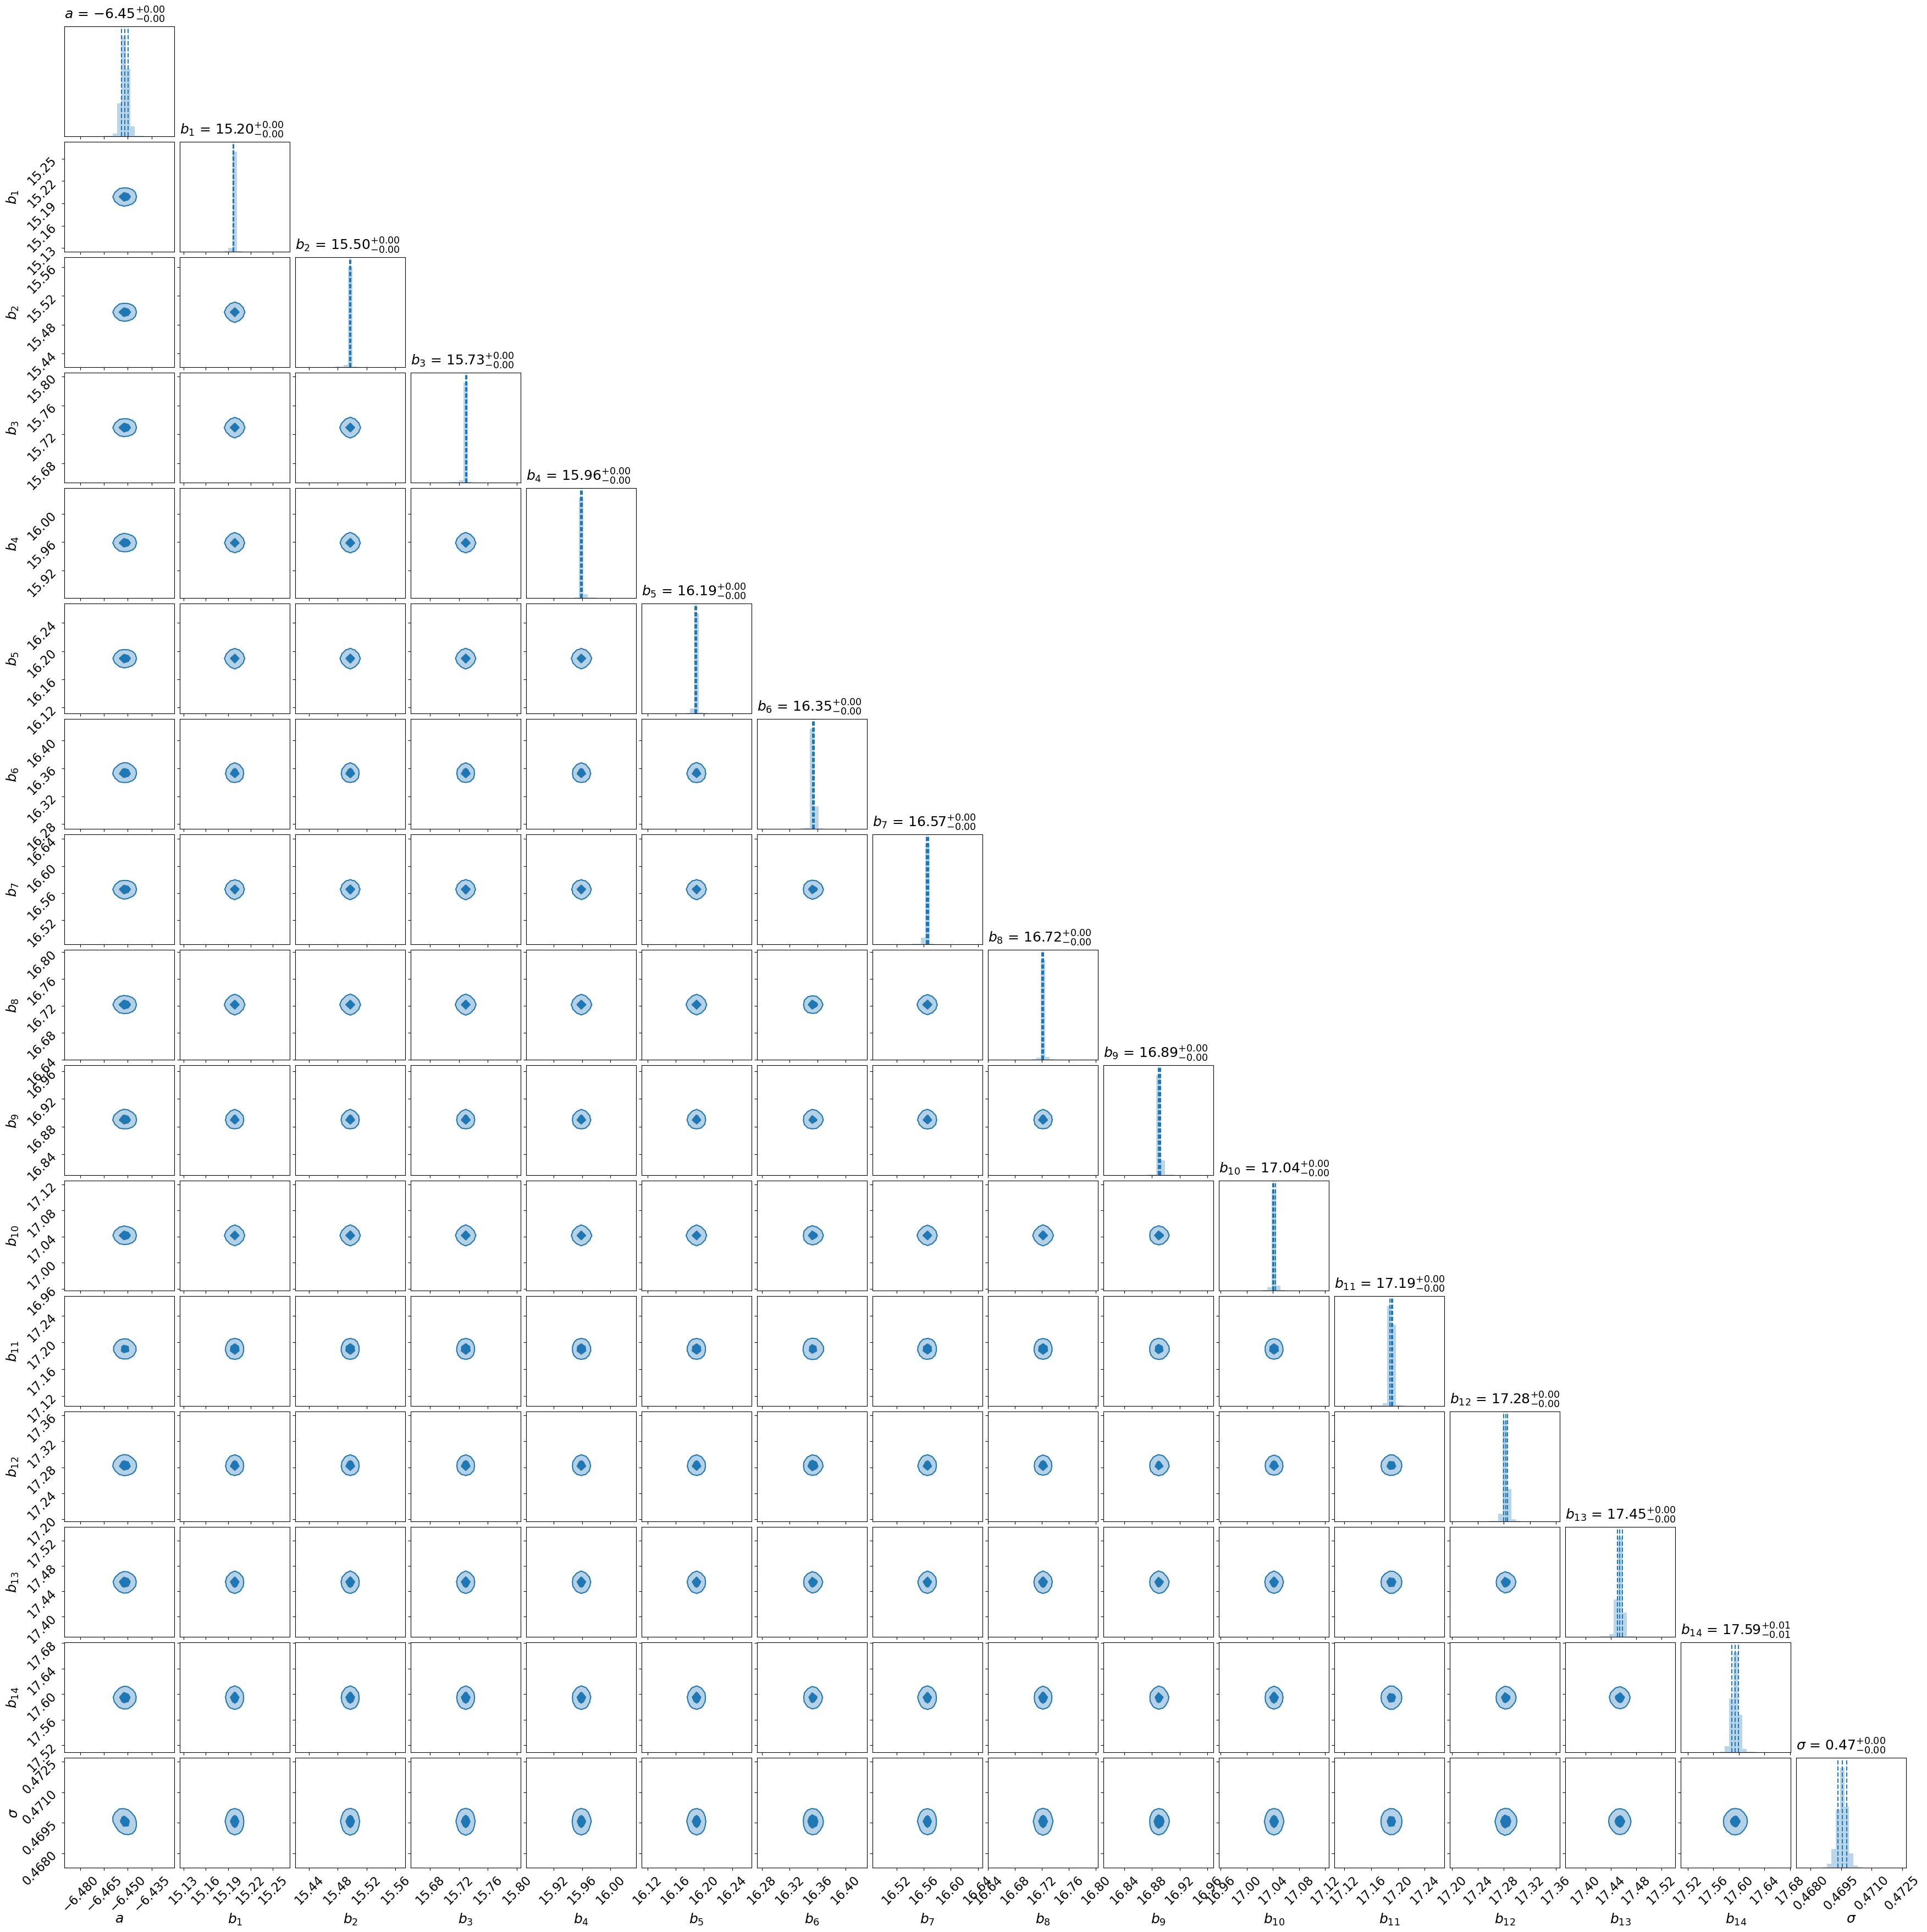

In [46]:
labels  = ['$a$']
labels += [f'$b_{{ {k+1} }}$' for k in np.arange(m)]
labels += [r'$\sigma$'] #+ [rf'$\sigma_{k}$' for k in np.arange(m)]

fig = corner(tfr_mcmc_samples.T, bins=25, smooth=1,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='tab:blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16)

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_corner0_20250717.png', 
#             dpi=150, 
#             facecolor='none');

### Plot the HyperFit Results

In [47]:
sigma_mcmc = np.percentile(tfr_mcmc_samples[-1], [16., 50., 84.])
a_mcmc = np.percentile(tfr_mcmc_samples[0], [16., 50., 84])
b_mcmc = []
# for k in range(1, m+2):
for k in range(1, m+1):
    b_mcmc.append(np.percentile(tfr_mcmc_samples[k], [16., 50., 84.]))
b_mcmc = np.asarray(b_mcmc)

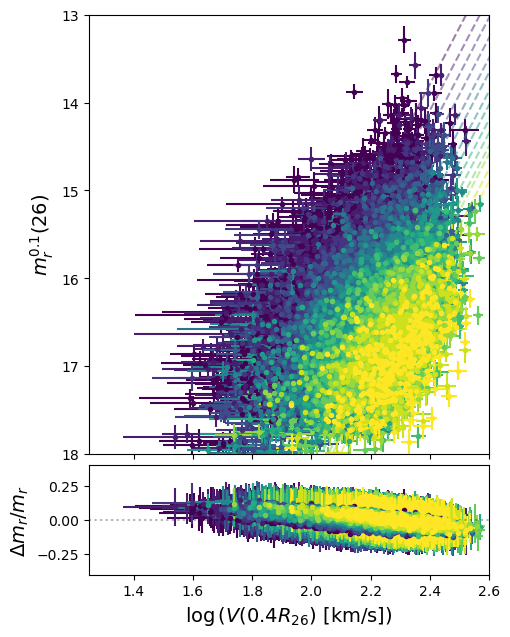

In [48]:
# fig, axes = plt.subplots(2,2, figsize=(10,7), sharex=True,
fig, axes = plt.subplots(2,1, figsize=(5,7), sharex=True,
                         gridspec_kw={'height_ratios':[4,1], 'hspace':0.04, 'wspace':0.25})

a_   = a_mcmc[1]
# b0pt = b_mcmc[0,1]
b_   = b_mcmc[:,1]#[1:]

#- Plot redshift bins
# ax = axes[0,0]
ax = axes[0]

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,m)))

_logv = np.arange(0, 3, 0.1) - logV0
for k in range(m):
    eb = ax.errorbar(x=logV0 + logV[k],#+1], 
                     y=mag[k],#+1], 
                     xerr=logV_err[k],#+1], 
                     yerr=mag_err[k],#+1],
                     fmt='.', 
                     label=f'{zbins[k]:.3f}-{zbins[k+1]:.3f}')

    ax.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), ls='--', alpha=0.5)

ax.set(xlim=[1.25, 2.6],
       ylim=[18, 13])
ax.set_ylabel(r'$m_r^{0.1} (26)$', fontsize=14)
# ax.legend(loc='upper left', fontsize=9, ncol=2);
'''
#- Plot calibrators
ax = axes[0,1]
eb = ax.errorbar(x=logV[0] + logV0, y=mag[0], xerr=logV_err[0], yerr=mag_err[0],
                 fmt='.', color='tab:blue', label=f'0-pt')

ax.plot(_logv + logV0, a_*_logv + b0pt, color=eb[0].get_color(), ls='--')#, label='fit')
ax.set(xlim=[1.25, 2.6],
       ylim=[-18, -24]
      )
ax.set_ylabel(r'$M_r^{0.1}(26) = m_r^{0.1}(26) - \mu$', fontsize=14)
ax.legend(loc='upper left', fontsize=9, ncol=2)
'''
#- Plot residuals: z-bins
# ax = axes[1,0]
ax = axes[1]

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,m)))

for k in range(m):
    logv_obs = logV[k]#+1]
    m_obs = mag[k]#+1]
    m_exp = (a_*logv_obs + b_[k])
    eb = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, 
                     xerr=logV_err[k],#+1], 
                     yerr=mag_err[k],#+1],
                     fmt='.')

ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1.25, 2.6],
       ylim=[-0.4, 0.4])
ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta m_r/m_r$', fontsize=14)
'''
#- Plot residuals: calibrators
ax = axes[1,1]

logv_obs = logV[0]
m_obs = mag[0]
m_exp = (a_*logv_obs + b0pt)

b = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, 
                xerr=logV_err[0], yerr=mag_err[0],
                fmt='.', color='tab:blue')
ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1.25, 2.6],
       ylim=[-0.4, 0.4])
ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta M_r/M_r$', fontsize=14)
'''
fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9);

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_0pt_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_fit0_20250717.png', 
#             dpi=150, 
#             facecolor='none')

In [49]:
print(f'slope (alpha): {-a_/2.5:.2f} +/- {np.sqrt(cov_tfr[0,0])/2.5:.3f}')

slope (alpha): 2.58 +/- 0.001


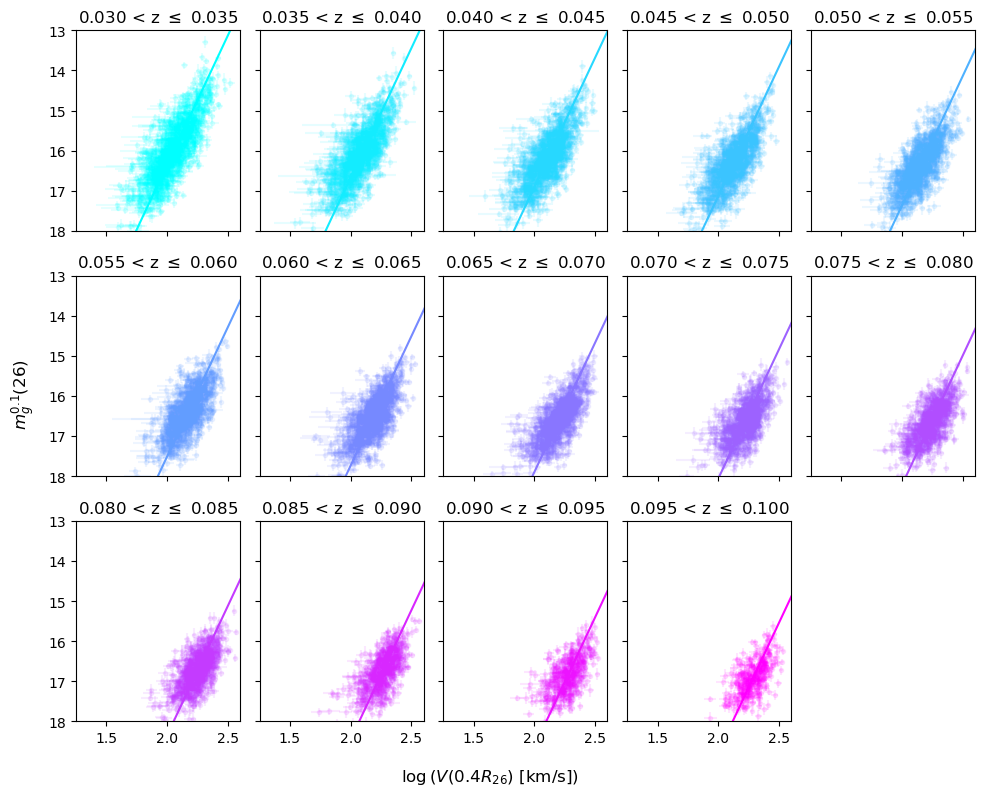

In [50]:
# fig, axs = plt.subplots(nrows=7, ncols=10, sharex=True, sharey=True, figsize=(20,16), tight_layout=True)
fig, axs = plt.subplots(nrows=3, ncols=5, sharex=True, sharey=True, figsize=(10,8), tight_layout=True)

color = iter(plt.cm.cool(np.linspace(0,1,m)))
for i in range(m):
    c = next(color)
    
    row = int(i/5)
    col = i%5
    
    eb = axs[row,col].errorbar(logV0 + logV[i],#+1], 
                               mag[i],#+1], 
                               xerr=logV_err[i],#+1], 
                               yerr=mag_err[i],#+1], 
                               fmt='.', color=c, alpha=0.1)
    axs[row,col].plot(_logv + logV0, a_*_logv + b_[i], color=c)
    
    axs[row,col].set(xlim=[1.25, 2.6], ylim=[18, 13], title=f'{zbins[i]:.3f} < z $\leq$ {zbins[i+1]:.3f}')

# Delete extra axes
fig.delaxes(axs[-1,-1])

fig.supxlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)')
fig.supylabel(r'$m_g^{0.1} (26)$');

# plt.savefig('../../Figures/Y1/TF_Y1_individual_cluster_calibration_0pt_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_fit0_20250717.png', 
#             dpi=150, 
#             facecolor='none')

# Apply TFR on z-band

In [51]:
#- Extract successful clusters
_zbin_ids = np.unique(caltab['Z_BIN_IDX'])
m = len(_zbin_ids)

#- Pack the results into arrays data and cov.
logV, logV_err = [], []
mag, mag_err = [], []
weights = []

logV0 = np.median(np.log10(caltab['V_0p4R26']))
print('logV0 =', logV0)

#- Loop over the redshift bins
for k, _zbin_id in enumerate(_zbin_ids):
    select_zbin = np.isin(caltab['Z_BIN_IDX'], _zbin_id)
    logV.append(np.log10(caltab['V_0p4R26'][select_zbin]) - logV0)
    logV_err.append(0.434*caltab['V_0p4R26_ERR'][select_zbin] / caltab['V_0p4R26'][select_zbin])
    mag.append(caltab['Z_MAG_SB26_CORR'][select_zbin])
    mag_err.append(caltab['Z_MAG_SB26_ERR_CORR'][select_zbin])
    weights.append(np.array(1/caltab['MAX_VOL_FRAC'][select_zbin]))

logV0 = 2.1816598102975977


## Multiline Fit using HyperFit

In [52]:
bounds = [[-20, 0]]                    # Bounds on a (slope)
bounds += m*[(-20, 20)]                # Bounds on b (intercepts: z-bins)
bounds += [(0,5)]                      # Bounds on sigma

results = hyperfit_line_multi(logV, mag, logV_err, mag_err, bounds, weights=weights, scatter=1)

a, b, sig_tfr, cov_tfr, tfr_mcmc_samples, hf_tfr = results

     fun: -13149246.708187317
     jac: array([  60.3497032 ,   90.15201776,  298.39572822,    3.91155449,
         23.28306244,  130.01262066,   -6.33299298,  -59.23211084,
         57.36946585,   30.73364242, -117.90542819,  -62.77113634,
         70.40798082,  -47.86997637,  -66.86895532,  654.90603481])
 message: 'Optimization terminated successfully.'
    nfev: 40900
     nit: 168
 success: True
       x: array([-7.21544044, 14.39310203, 14.6639579 , 14.89382273, 15.12051403,
       15.33043721, 15.49541596, 15.69077914, 15.84221942, 15.99233191,
       16.13861014, 16.2661785 , 16.35367343, 16.50778276, 16.65900706,
        0.36200123])
Ndim: 16 14


100%|██████████| 1000/1000 [00:57<00:00, 17.36it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [128.54765817  37.36701043  24.03617363  21.31167044  32.10861789
  42.51601838  29.21658794  24.53538071  72.48032995  42.38747723
  62.1750559   94.62381181  50.49246837 100.56632474  65.50619529
  99.96098037] / 6427.382908731736


100%|██████████| 1000/1000 [00:59<00:00, 16.75it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [97.34407551 32.14401418 33.99803592 24.87445894 26.30702981 44.68972419
 39.30073813 21.56741173 44.98158929 39.28758885 47.18597403 51.08486039
 59.93494289 77.93583644 72.79832508 97.10078228] / 4867.203775644002


100%|██████████| 1000/1000 [00:54<00:00, 18.41it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [106.34382192  27.83609174  34.91900532  24.67486748  25.44413886
  37.93983866  32.1027524   22.16187349  40.10174219  33.44914866
  40.32641583  49.19103463  59.4506621   84.33558051  68.16250425
  92.86655874] / 5317.191096188918


100%|██████████| 1000/1000 [00:57<00:00, 17.53it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 88.0251704   27.02325642  24.06782121  24.22584369  25.99018788
  37.9709897   38.47576532  24.57696146  42.96468423  44.60510533
  53.66966963  56.79224876  61.7015106   85.54469533  83.07368128
 124.86768603] / 6243.384301425728


100%|██████████| 1000/1000 [00:56<00:00, 17.57it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [100.17998489  25.27218007  22.46764913  22.85757284  33.46353731
  36.92691411  34.47160577  24.11765241  40.95014496  43.48808676
  74.78344501  56.46362234  58.13289954  85.88093546  90.3136268
 115.94116996] / 5797.05849798877


100%|██████████| 1000/1000 [00:54<00:00, 18.29it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 98.0408923   25.99663698  22.33500264  21.32627169  37.13395014
  37.39485539  37.99924959  25.35392096  42.50798695  47.529192
  67.29523062  55.10346378  72.93344829  84.25175157  91.73263901
 129.68672251] / 6484.336125659848


100%|██████████| 1000/1000 [00:55<00:00, 17.88it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 96.55291458  25.62189756  22.07687507  20.61711814  41.72687834
  33.87407984  39.59532952  24.43030305  41.0636445   44.65548833
  58.0132074   60.99614641  70.20708055  84.80233384  96.38371974
 129.59725488] / 6479.86274396415


100%|██████████| 1000/1000 [00:56<00:00, 17.74it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 92.17263092  25.75316131  22.31152766  21.22559538  43.03850617
  36.56985409  44.25833572  29.99597386  53.89559395  65.10728759
  64.73612617  64.10266178  70.39252228 122.92474483 102.97607431
 145.59643926] / 7279.82196284965


100%|██████████| 1000/1000 [00:55<00:00, 17.96it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 91.22946843  26.54995228  23.2217544   20.34295315  42.87685046
  34.75802967  43.80878996  28.54359944  51.41763123  64.35644505
  59.29954403  60.80707656  69.64069001 120.29885796 104.04691163
 146.16890815] / 7308.445407326366


100%|██████████| 1000/1000 [00:56<00:00, 17.70it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 91.39088364  27.56340029  32.66085715  21.13362052  41.97404627
  34.99875896  43.91431658  29.2521826   54.66851997  73.94711234
  51.25779153  57.5887072   76.05557115 121.85673997  95.20846928
 242.26318784] / 12113.159391776211


100%|██████████| 1000/1000 [00:57<00:00, 17.29it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 94.6079548   27.68812847  31.15353203  21.34656687  40.8851269
  34.21678626  44.75663113  28.58605914  51.19836917  66.60817095
  56.19914645  55.75893555 101.12592406 125.48256738  95.36811062
 308.96326864] / 15448.163432165842


100%|██████████| 1000/1000 [00:56<00:00, 17.77it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 91.72279614  27.86939443  31.93085762  24.28363894  39.73537664
  33.16003469  46.17084199  30.14954136  53.21535359  66.20132836
  57.88000056  55.2273424   99.8578057  127.76841056  99.87102427
 299.13010562] / 14956.505280892585


100%|██████████| 1000/1000 [00:56<00:00, 17.84it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 92.62541607  27.76537732  30.27228299  25.02494417  39.71533135
  46.16299263  45.85486106  29.25404622  54.00644103  63.50813759
  57.93223476  54.82308859 111.15809929 126.99397875 104.24257006
 290.37940051] / 14518.97002554833


100%|██████████| 1000/1000 [01:02<00:00, 16.06it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 95.49192342  27.38518249  30.51452386  24.96901634  34.85211531
  46.62827624  48.50962466  29.67369363  53.94956765  64.17009988
  54.274506    54.19181198 107.00612448 124.27735023 100.42066776
 233.73564288] / 11686.782143838778


100%|██████████| 1000/1000 [00:57<00:00, 17.27it/s]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [100.20767471  29.306109    30.06700554  24.02505729  34.85863747
  44.01585508  48.18942007  28.37250951  55.39312556  63.49054534
  51.99784449  51.73275644 103.03186701 117.03779763  99.4236072
 286.5965601 ] / 14329.828005091145


100%|██████████| 1000/1000 [01:00<00:00, 16.66it/s]


Niterations/Max Iterations:  16000 / 100000
Integrated ACT/Min Convergence Iterations:  [101.21835895  29.04711684  30.13032471  24.39648608  34.55039675
  50.66333664  47.93816202  25.48580583  50.45711683  48.29453956
  57.74342786  53.88571452 102.93691722 101.9241043   98.34830261
 204.86932778] / 10243.466389009176


100%|██████████| 1000/1000 [00:55<00:00, 18.03it/s]


Niterations/Max Iterations:  17000 / 100000
Integrated ACT/Min Convergence Iterations:  [104.21822779  29.12911124  30.03124377  24.05169005  34.75749712
  48.18065379  47.43154348  25.63390296  52.67869055  45.18178642
  56.4170563   52.24585775 103.24723511 102.93020503 101.56561556
 207.74189017] / 10387.09450847375


100%|██████████| 1000/1000 [00:56<00:00, 17.81it/s]


Niterations/Max Iterations:  18000 / 100000
Integrated ACT/Min Convergence Iterations:  [101.05148039  28.63905741  30.44870235  25.71927751  34.16100968
  48.76008497  48.33232977  25.54069909  52.05448767  46.8906507
  57.43816679  53.96571546 107.9289454  100.3566028   94.91260927
 220.67858487] / 11033.929243715695


100%|██████████| 1000/1000 [00:56<00:00, 17.72it/s]


Niterations/Max Iterations:  19000 / 100000
Integrated ACT/Min Convergence Iterations:  [103.33602886  28.35571334  31.05175897  25.65154674  33.57119899
  48.90886481  46.20748949  25.74823203  49.75550453  48.58312785
  57.49209816  53.99193568 103.28751037 104.11653266  98.89282447
 246.43012002] / 12321.506000945728


100%|██████████| 1000/1000 [01:00<00:00, 16.55it/s]


Niterations/Max Iterations:  20000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 99.7073958   28.45094893  26.366612    24.50136827  33.1109579
  48.88301084  47.1948857   25.82165378  48.7599031   48.05365788
  56.6744215   56.88888204  90.70162853 117.60896466  97.79513734
 209.72437105] / 10486.218552342087


100%|██████████| 1000/1000 [00:53<00:00, 18.63it/s]


Niterations/Max Iterations:  21000 / 100000
Integrated ACT/Min Convergence Iterations:  [101.71228266  29.02172264  26.88886708  24.38351957  33.36113749
  48.42592176  44.62790719  25.64126045  48.95678253  46.19388274
  55.65562084  57.30157281  88.89954675 118.0229787  102.59721472
 227.90908545] / 11395.454272497864


100%|██████████| 1000/1000 [00:54<00:00, 18.45it/s]


Niterations/Max Iterations:  22000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 99.80982484  28.23168572  26.34504576  24.16846924  32.75504196
  47.9982959   44.18768113  28.42567314  50.38209524  47.75140433
  56.58277337  64.21086645  87.83275361 115.07989636 100.89237617
 204.7695784 ] / 10238.478919983914


100%|██████████| 1000/1000 [00:57<00:00, 17.35it/s]


Niterations/Max Iterations:  23000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 98.91374455  28.96312297  26.77194883  24.29034082  35.14690726
  47.96276475  43.71768785  28.67711273  50.42179242  48.64118426
  54.72781006  67.17337827  94.81329993 129.45064157 114.24750702
 214.48717999] / 10724.358999671162


100%|██████████| 1000/1000 [00:57<00:00, 17.37it/s]


Niterations/Max Iterations:  24000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 97.86096928  29.04672624  26.39843582  23.77280369  35.68564034
  49.07234843  43.96580745  28.30176252  49.80813901  51.85256548
  69.07252304  67.53788256  91.65464741 133.93507707 113.8278417
 221.75907904] / 11087.953951867348


100%|██████████| 1000/1000 [00:57<00:00, 17.52it/s]


Niterations/Max Iterations:  25000 / 100000
Integrated ACT/Min Convergence Iterations:  [101.27751199  28.92450321  26.19161179  23.61657838  35.05641637
  48.68433681  43.53190391  28.09027662  49.15672022  51.84422636
  66.66983789  68.42737404  89.26348417 129.24097468 113.61314103
 218.96090358] / 10948.045178953264


In [53]:
temp_outfile = open('/pscratch/sd/s/sgmoore1/TF/pickles/Y3/cov_ab_jura_jointTFR_HDBSCAN_z_band_nokcorr.pickle', 
                    'wb')
pickle.dump((cov_tfr, tfr_mcmc_samples, logV0, zmin, zmax, dz, zbins), temp_outfile)
temp_outfile.close()

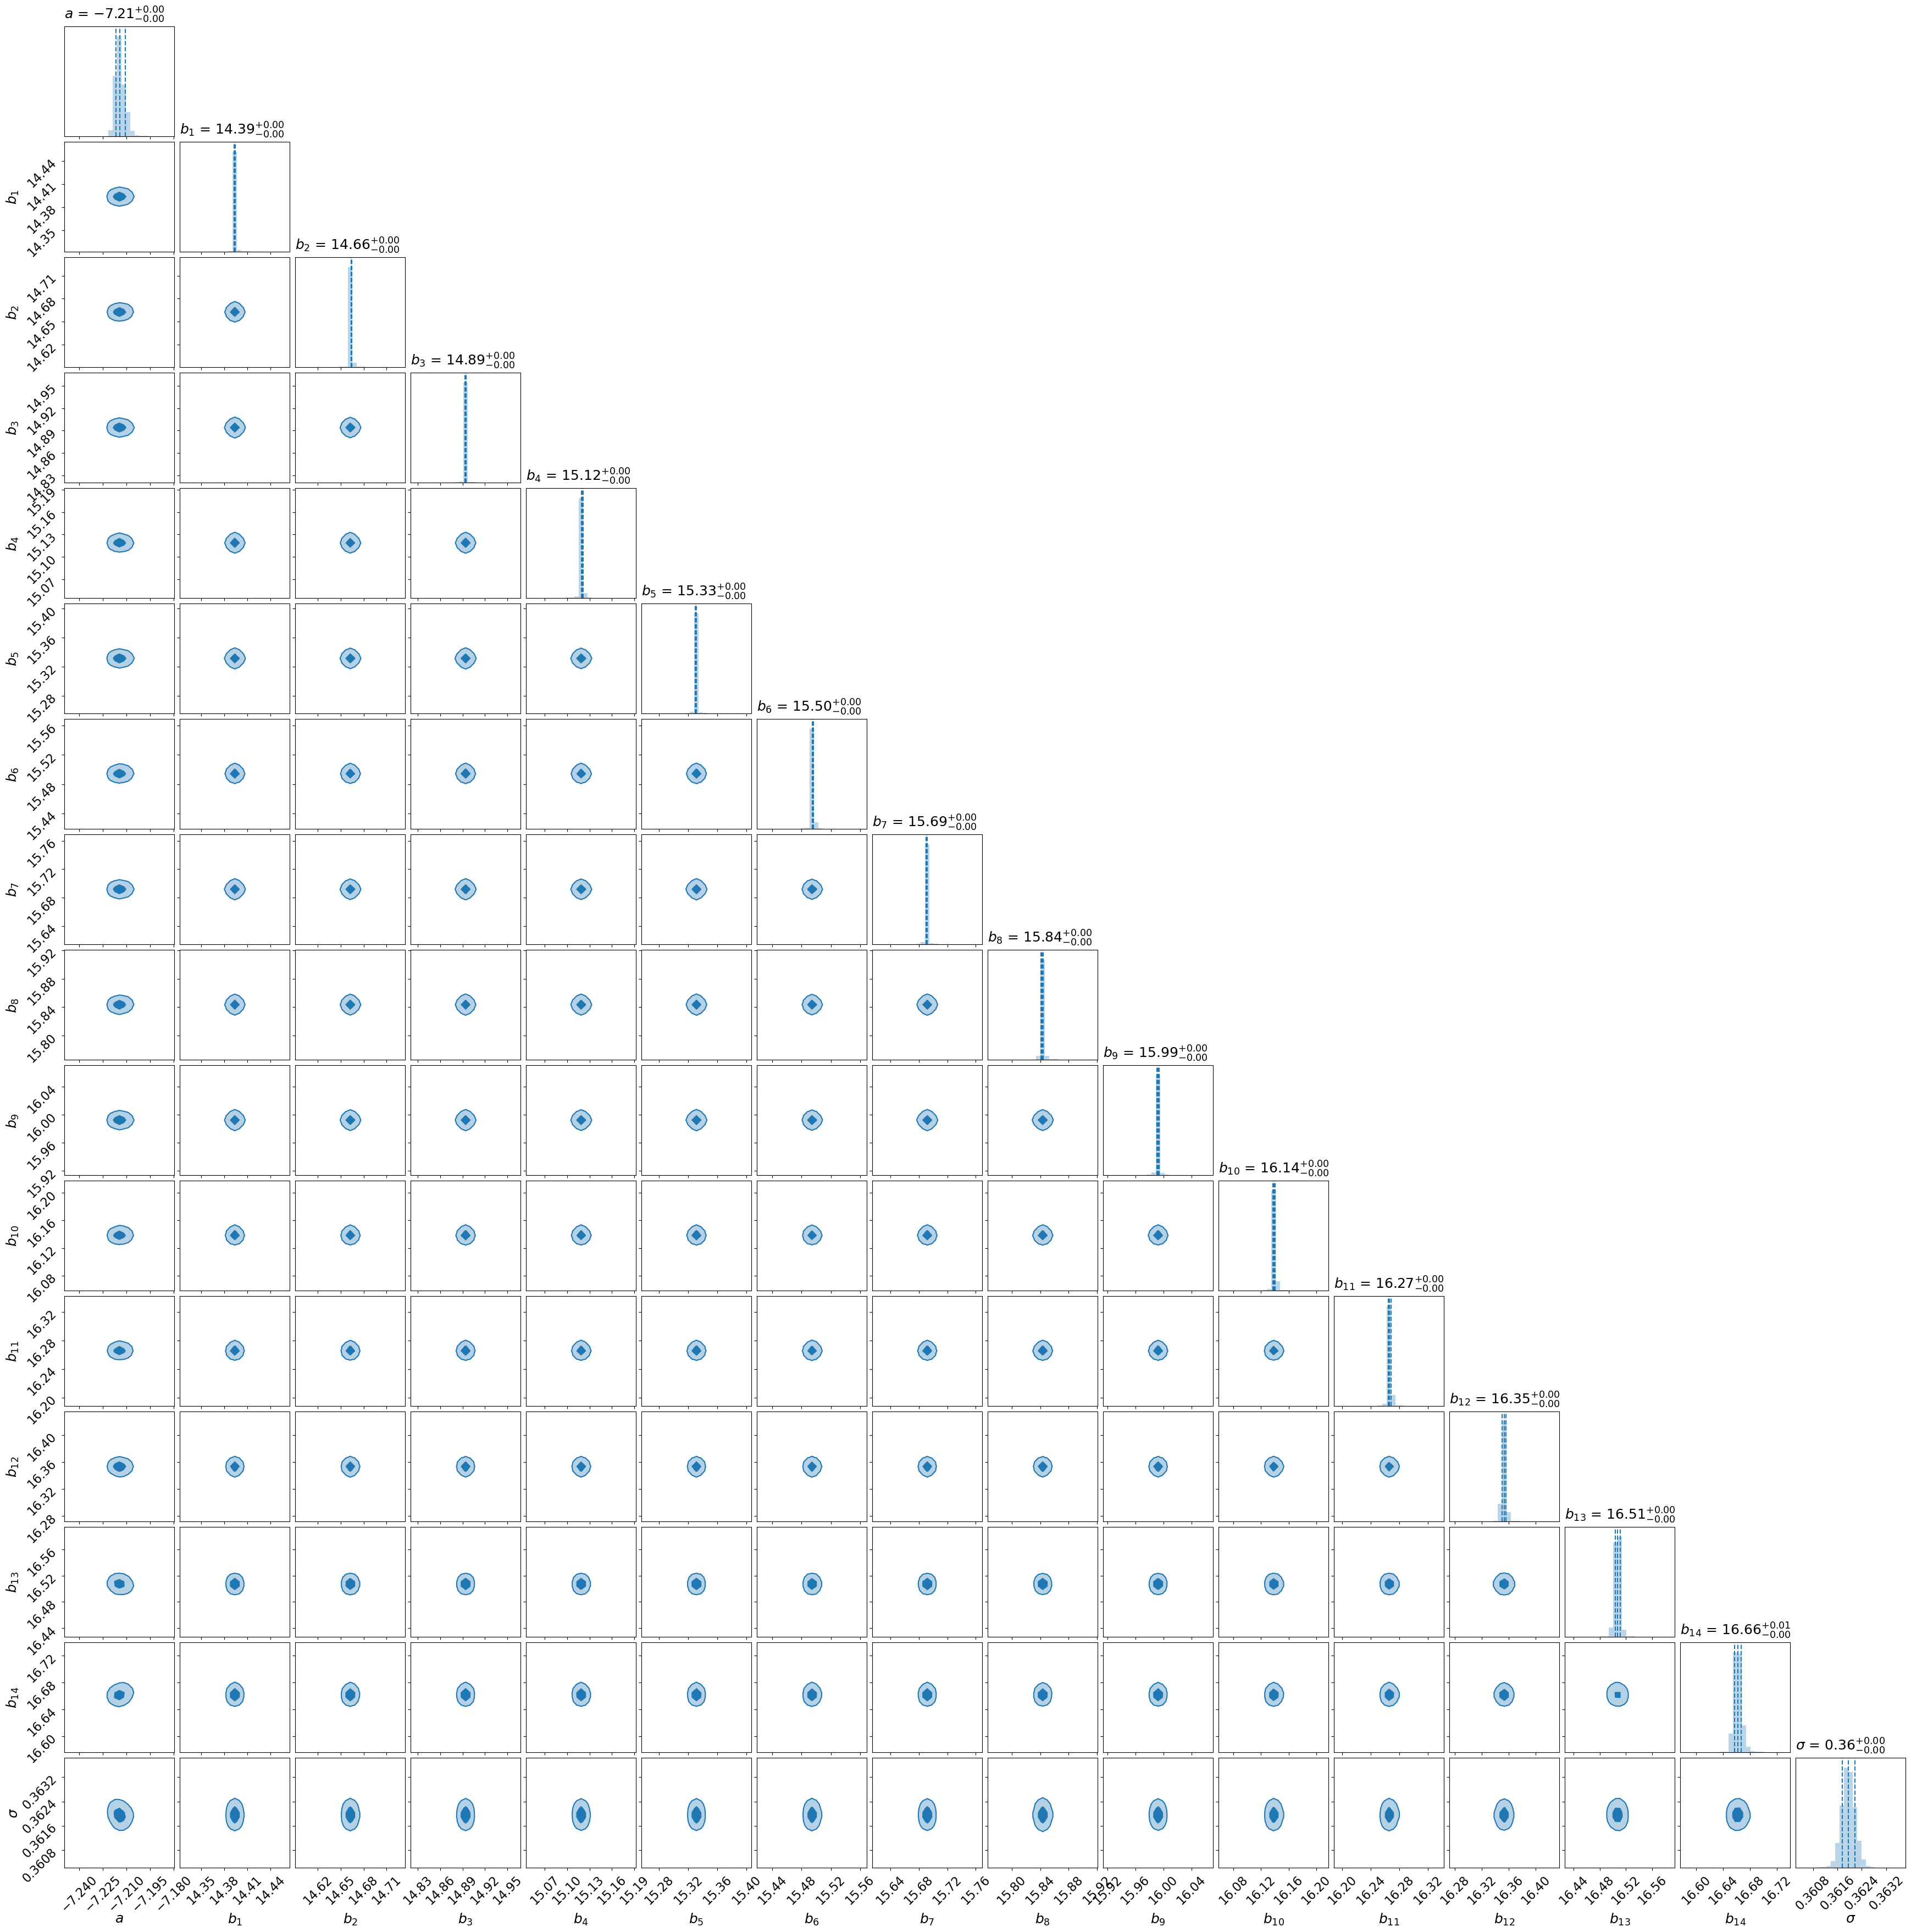

In [54]:
labels  = ['$a$']
labels += [f'$b_{{ {k+1} }}$' for k in np.arange(m)]
labels += [r'$\sigma$'] #+ [rf'$\sigma_{k}$' for k in np.arange(m)]

fig = corner(tfr_mcmc_samples.T, bins=25, smooth=1,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='tab:blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16)

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_corner0_20250717.png', 
#             dpi=150, 
#             facecolor='none');

### Plot the HyperFit Results

In [55]:
sigma_mcmc = np.percentile(tfr_mcmc_samples[-1], [16., 50., 84.])
a_mcmc = np.percentile(tfr_mcmc_samples[0], [16., 50., 84])
b_mcmc = []
# for k in range(1, m+2):
for k in range(1, m+1):
    b_mcmc.append(np.percentile(tfr_mcmc_samples[k], [16., 50., 84.]))
b_mcmc = np.asarray(b_mcmc)

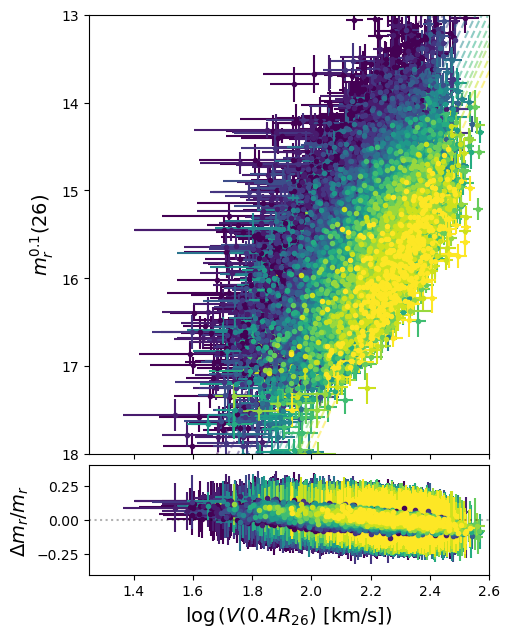

In [56]:
# fig, axes = plt.subplots(2,2, figsize=(10,7), sharex=True,
fig, axes = plt.subplots(2,1, figsize=(5,7), sharex=True,
                         gridspec_kw={'height_ratios':[4,1], 'hspace':0.04, 'wspace':0.25})

a_   = a_mcmc[1]
# b0pt = b_mcmc[0,1]
b_   = b_mcmc[:,1]#[1:]

#- Plot redshift bins
# ax = axes[0,0]
ax = axes[0]

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,m)))

_logv = np.arange(0, 3, 0.1) - logV0
for k in range(m):
    eb = ax.errorbar(x=logV0 + logV[k],#+1], 
                     y=mag[k],#+1], 
                     xerr=logV_err[k],#+1], 
                     yerr=mag_err[k],#+1],
                     fmt='.', 
                     label=f'{zbins[k]:.3f}-{zbins[k+1]:.3f}')

    ax.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), ls='--', alpha=0.5)

ax.set(xlim=[1.25, 2.6],
       ylim=[18, 13])
ax.set_ylabel(r'$m_r^{0.1} (26)$', fontsize=14)
# ax.legend(loc='upper left', fontsize=9, ncol=2);
'''
#- Plot calibrators
ax = axes[0,1]
eb = ax.errorbar(x=logV[0] + logV0, y=mag[0], xerr=logV_err[0], yerr=mag_err[0],
                 fmt='.', color='tab:blue', label=f'0-pt')

ax.plot(_logv + logV0, a_*_logv + b0pt, color=eb[0].get_color(), ls='--')#, label='fit')
ax.set(xlim=[1.25, 2.6],
       ylim=[-18, -24]
      )
ax.set_ylabel(r'$M_r^{0.1}(26) = m_r^{0.1}(26) - \mu$', fontsize=14)
ax.legend(loc='upper left', fontsize=9, ncol=2)
'''
#- Plot residuals: z-bins
# ax = axes[1,0]
ax = axes[1]

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,m)))

for k in range(m):
    logv_obs = logV[k]#+1]
    m_obs = mag[k]#+1]
    m_exp = (a_*logv_obs + b_[k])
    eb = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, 
                     xerr=logV_err[k],#+1], 
                     yerr=mag_err[k],#+1],
                     fmt='.')

ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1.25, 2.6],
       ylim=[-0.4, 0.4])
ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta m_r/m_r$', fontsize=14)
'''
#- Plot residuals: calibrators
ax = axes[1,1]

logv_obs = logV[0]
m_obs = mag[0]
m_exp = (a_*logv_obs + b0pt)

b = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, 
                xerr=logV_err[0], yerr=mag_err[0],
                fmt='.', color='tab:blue')
ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1.25, 2.6],
       ylim=[-0.4, 0.4])
ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta M_r/M_r$', fontsize=14)
'''
fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9);

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_0pt_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_fit0_20250717.png', 
#             dpi=150, 
#             facecolor='none')

In [57]:
print(f'slope (alpha): {-a_/2.5:.2f} +/- {np.sqrt(cov_tfr[0,0])/2.5:.3f}')

slope (alpha): 2.89 +/- 0.001


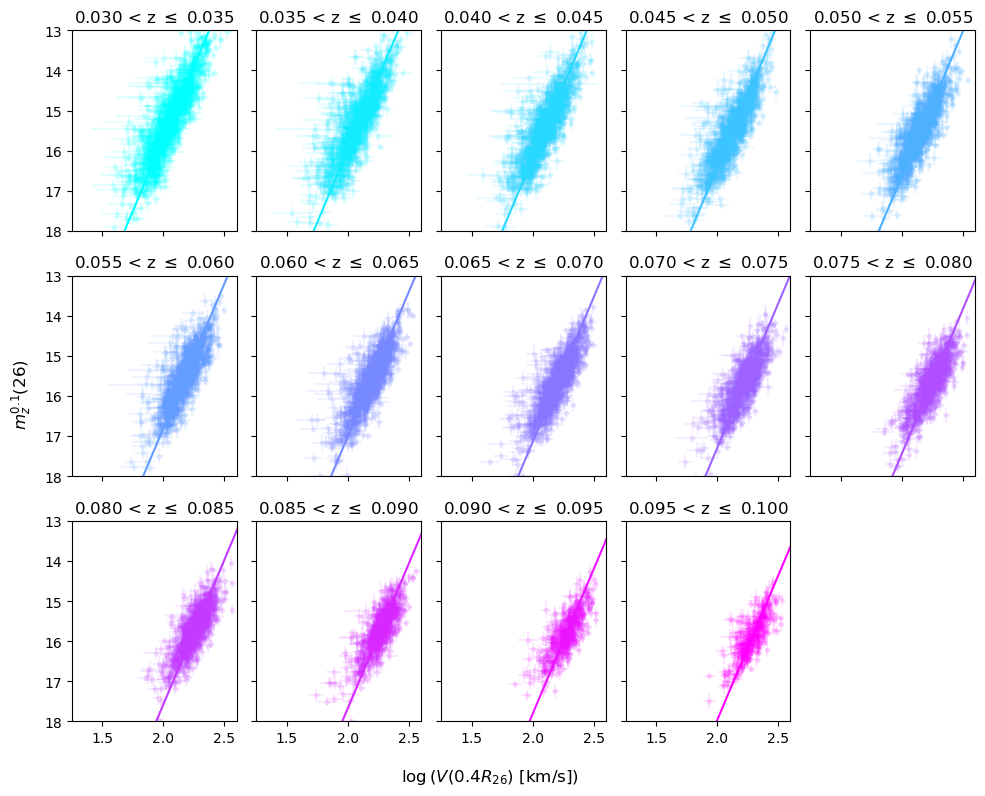

In [58]:
# fig, axs = plt.subplots(nrows=7, ncols=10, sharex=True, sharey=True, figsize=(20,16), tight_layout=True)
fig, axs = plt.subplots(nrows=3, ncols=5, sharex=True, sharey=True, figsize=(10,8), tight_layout=True)

color = iter(plt.cm.cool(np.linspace(0,1,m)))
for i in range(m):
    c = next(color)
    
    row = int(i/5)
    col = i%5
    
    eb = axs[row,col].errorbar(logV0 + logV[i],#+1], 
                               mag[i],#+1], 
                               xerr=logV_err[i],#+1], 
                               yerr=mag_err[i],#+1], 
                               fmt='.', color=c, alpha=0.1)
    axs[row,col].plot(_logv + logV0, a_*_logv + b_[i], color=c)
    
    axs[row,col].set(xlim=[1.25, 2.6], ylim=[18, 13], title=f'{zbins[i]:.3f} < z $\leq$ {zbins[i+1]:.3f}')

# Delete extra axes
fig.delaxes(axs[-1,-1])

fig.supxlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)')
fig.supylabel(r'$m_z^{0.1} (26)$');

# plt.savefig('../../Figures/Y1/TF_Y1_individual_cluster_calibration_0pt_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_fit0_20250717.png', 
#             dpi=150, 
#             facecolor='none')